# Data Augmentation

This notebook implements data augmentation techniques for seismic signals. For each original signal, multiple augmented versions are generated using:

1. Amplitude modulation with large window (2000 samples)
2. Time shift (15%) + soft noise (4%)
3. Adaptive augmentation based on signal duration

## Key Components:

### Core Functions
- **amplitude_modulation**: Applies time-varying amplitude changes
- **time_shift**: Creates controlled temporal shifts while preserving P-arrival
- **add_noise**: Introduces calibrated Gaussian noise
- **amplitude_modulation_adaptive**: Adapts modulation based on signal length

### Processing Functions
- **augment_seismic_data**: Main augmentation pipeline
- **augment_single_file**: Processes individual files
- **process_all_files_adaptive**: Handles batch processing

### Analysis Functions
- **analyze_signal_suitability**: Evaluates signals for augmentation
- **plot_augmentation_comparison**: Visualizes original vs augmented

## Data Organization:

- Original data → training/
- Validation split → training_augmented/val/
- Training split → training_augmented/train/
- Augmented data → training_augmented/augmented/

## Augmentation Strategy:

1. **Short signals** (<40s):
   - Small time shifts (±15%)
   - Conservative amplitude modulation

2. **Medium signals** (40-80s):
   - Time shifts in 1-20s range
   - Moderate amplitude changes

3. **Long signals** (>80s):
   - Full range shifts (1-20s, 25-35s)
   - Aggressive transformations

## Quality Assurance:
- SNR validation pre/post augmentation
- P-wave characteristic preservation
- Documented transformation parameters

## Setup and Imports

This section configures the required libraries and defines data paths:

- **Libraries**: numpy, scipy, pandas, obspy, etc. for signal processing
- **Data Paths**: Configures paths for different data splits:
  - Training data
  - Testing data
  - Augmented data
  - CSV files with arrival times

The code also creates required directories and loads the training CSV.

In [ ]:
import numpy as np
from scipy import signal
import pandas as pd
import os
from obspy import read
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
import tqdm

# Define paths for data organization
train_data_path = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training'
testing_data_path = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/testing'
train_csv_path = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/raw/VT_P_training.csv'
augmented_data_path = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training_augmented'
val_data_path = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training_augmented/val'
train_augment_data_path = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training_augmented/train'
train_augment_data_path_2 = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training_augmented/augmented'
# Crear directorio para datos aumentados si no existe
if not os.path.exists(augmented_data_path):
    os.makedirs(augmented_data_path)

# Leer CSV con tiempos de llegada
df = pd.read_csv(train_csv_path) 

## Funciones principales de aumento

Implementación de las principales técnicas de aumento de señal:

1. **amplitude_modulation(signal_data, window_size)**:
- Aplica cambios de amplitud variables en el tiempo mediante ventanas
- Suaviza las transiciones entre ventanas

2. **time_shift(signal_data, sample_rate, p_arrival_time)**:
- Crea desplazamientos temporales controlados
- Conserva la información del tiempo de llegada P

3. **add_noise(signal_data, noise_level)**:
- Añade ruido gaussiano calibrado
- Controla el nivel de ruido en relación con la señal

4. **amplitude_modulation_adaptive(signal_data, duration)**:
- Adapta la modulación en función de la longitud de la señal
- Utiliza diferentes parámetros para señales cortas y largas

In [122]:
def amplitude_modulation(signal_data, window_size=2000):
    """Applies time-varying amplitude modulation.
    Args:
        signal_data: Original signal
        window_size: Window size for modulation
    Returns:
        array: Modulated signal"""
    envelope = np.ones_like(signal_data)
    num_windows = len(signal_data) // window_size
    for i in range(num_windows):
        start = i * window_size
        end = start + window_size
        envelope[start:end] *= np.random.uniform(0.8, 1.2)
    # Smooth transitions between windows using scipy.signal
    envelope = signal.savgol_filter(envelope, window_length=501, polyorder=3)
    return signal_data * envelope

def time_shift(signal_data, sample_rate, p_arrival_time, shift_range=0.15):
    """Shifts the signal in time while preserving the P-arrival time.
    Args:
        signal_data: Original signal
        sample_rate: Sampling rate
        p_arrival_time: P-arrival time in seconds
        shift_range: Maximum shift range as a fraction of the length
    Returns:
        tuple: (shifted signal, new P-arrival time)"""
    # Convert P-arrival time to samples
    p_sample = int(p_arrival_time * sample_rate)
    
    # Calculate the maximum allowed shift
    max_shift = int(len(signal_data) * shift_range)
    
    # Generate a random shift that keeps the P-arrival time within the signal
    min_shift = -min(p_sample, max_shift)  # Do not shift beyond the start
    max_shift = min(len(signal_data) - p_sample, max_shift)  # Do not shift beyond the end
    shift = int(np.random.uniform(min_shift, max_shift))
    
    # Apply the shift
    shifted_signal = np.roll(signal_data, shift)
    new_p_time = p_arrival_time + (shift / sample_rate)
    
    return shifted_signal, new_p_time

def add_noise(signal_data, noise_level=0.02):
    """Adds Gaussian noise to the signal.
    Args:
        signal_data: Original signal
        noise_level: Noise level (proportion of the standard deviation of the signal)
    Returns:
        array: Signal with noise"""
    noise = np.random.normal(0, noise_level * np.std(signal_data), len(signal_data))
    return signal_data + noise

def amplitude_modulation_adaptive(signal_data, duration_seconds, sample_rate):
    """Applies adaptive amplitude modulation based on signal duration.
    Args:
        signal_data: Original signal
        duration_seconds: Signal duration in seconds
        sample_rate: Sampling rate in Hz
    Returns:
        array: Modulated signal"""
    # Adapt window size based on signal duration
    if duration_seconds < 40:
        # For short signals, use smaller windows and more aggressive modulation
        window_size = min(500, len(signal_data) // 4)
        mod_range = (0.6, 1.4)  # More aggressive amplitude changes
    else:
        window_size = 2000
        mod_range = (0.8, 1.2)

    envelope = np.ones_like(signal_data)
    num_windows = len(signal_data) // window_size

    # Generate smoother transitions between windows
    for i in range(num_windows):
        start = i * window_size
        end = start + window_size
        # Use sine wave modulation for smoother transitions
        mod = np.random.uniform(*mod_range)
        window = np.sin(np.linspace(0, np.pi, window_size)) * (mod - 1) + 1
        envelope[start:end] *= window

    # Handle remaining samples
    if len(signal_data) % window_size != 0:
        start = num_windows * window_size
        mod = np.random.uniform(*mod_range)
        remaining = len(signal_data) - start
        window = np.sin(np.linspace(0, np.pi, remaining)) * (mod - 1) + 1
        envelope[start:] *= window

    # Apply additional smoothing
    envelope = signal.savgol_filter(envelope, window_length=min(501, len(signal_data) // 10), polyorder=3)

    return signal_data * envelope

# Modificar augment_seismic_data para usar la nueva función
def augment_seismic_data(signal_data, sample_rate, p_arrival_time):
    """Applies selected data augmentation techniques to the seismic signal.
    Args:
        signal_data: Original seismic signal
        sample_rate: Sampling rate
        p_arrival_time: P-arrival time in seconds
    Returns:
        tuple: (augmented signals, new arrival times)"""
    augmented_signals = []
    augmented_arrivals = []
    
    duration_seconds = len(signal_data) / sample_rate
    
    # 1. Enhanced amplitude modulation
    signal_amp = amplitude_modulation_adaptive(signal_data.copy(), duration_seconds, sample_rate)
    augmented_signals.append(signal_amp)
    augmented_arrivals.append(p_arrival_time)
    
    # 2. Time shift + soft noise con parámetros ajustados
    shift_range = 0.25 if duration_seconds < 40 else 0.15  # Mayor rango para señales cortas
    noise_level = 0.04 if duration_seconds < 40 else 0.02  # Más ruido para señales cortas
    
    signal_shifted, new_p_time = time_shift(signal_data.copy(), sample_rate, p_arrival_time, shift_range=shift_range)
    signal_shifted = add_noise(signal_shifted, noise_level=noise_level)
    augmented_signals.append(signal_shifted)
    augmented_arrivals.append(new_p_time)
    
    return np.array(augmented_signals), np.array(augmented_arrivals)

## Helper Functions

Supporting functions for data processing:

1. **get_relative_p_time()**: Converts absolute to relative P-arrival time

2. **augment_single_file()**: Processes individual seismic files:
   - Reads original signal
   - Applies augmentations
   - Saves augmented versions

3. **plot_augmentation_comparison()**: Visualization utilities:
   - Shows original vs augmented signals
   - Displays P-arrival markers
   - Provides signal statistics

In [123]:
def get_relative_p_time(tr, absolute_p_time):
    """Converts the absolute P-arrival time to relative time within the signal.
    Args:
        tr: Trace object from ObsPy
        absolute_p_time: Absolute P-arrival time in seconds
    Returns:
        float: Relative P-arrival time in seconds"""
    start_time = tr.stats.starttime.timestamp
    return absolute_p_time - start_time

def augment_single_file(mseed_file, absolute_p_time, data_path):
    """Applies data augmentation to a seismic file and saves the augmented versions.
    Args:
        mseed_file: Name of the MSEED file to augment
        absolute_p_time: Absolute P-arrival time in seconds
    Returns:
        int: Number of augmented signals generated"""
    # Read the original signal
    file_path = os.path.join(train_data_path, mseed_file)
    st = read(file_path)
    tr = st[0]
    
    # Convert absolute P-arrival time to relative
    relative_p_time = get_relative_p_time(tr, absolute_p_time)
    
    # Generate augmented signals
    augmented_signals, augmented_arrivals = augment_seismic_data(
        tr.data,
        tr.stats.sampling_rate,
        relative_p_time
    )

    # Save each augmented signal
    for i, (aug_signal, aug_arrival) in enumerate(zip(augmented_signals, augmented_arrivals)):
        aug_st = st.copy()
        aug_st[0].data = aug_signal
        
        base_name = os.path.splitext(mseed_file)[0]
        aug_filename = f"{base_name}_aug{i+1}.mseed"
        # TODO: hay que cambiar esto para que reciva el directiorio de salida
        output_path = os.path.join(data_path, aug_filename)
        
        aug_st.write(output_path, format='MSEED')
    
    return len(augmented_signals)

In [124]:
def plot_augmentation_comparison(mseed_file):
    """Visualizes the original signal and its two augmented versions.
    Args:
        mseed_file: Name of the MSEED file to analyze"""
    # Read original signal
    file_path = os.path.join(train_data_path, mseed_file)
    st = read(file_path)
    tr = st[0]
    
    # Get and convert P-arrival time
    file_id = int(mseed_file.split('.')[0])
    row = df[df['archivo'] == file_id]
    if row.empty:
        print(f"No se encontró el tiempo P para {mseed_file}")
        return
        
    p_time = row.iloc[0]['lec_p']
    relative_p_time = get_relative_p_time(tr, p_time)
    
    # Generate augmented signals
    augmented_signals, augmented_arrivals = augment_seismic_data(
        tr.data, tr.stats.sampling_rate, relative_p_time)

    # Create time vector
    times = np.arange(len(tr.data)) / tr.stats.sampling_rate

    # Adjust the visualization range around the P-arrival time
    window = 50  # seconds before and after the P-arrival time
    start_idx = max(0, int((relative_p_time - window) * tr.stats.sampling_rate))
    end_idx = min(len(times) - 1, int((relative_p_time + window) * tr.stats.sampling_rate))

    # Configure subplots with more height for better visualization
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
    fig.suptitle(f'Comparación de señales - {mseed_file}\nVentana de ±50 segundos alrededor del tiempo P', y=0.95)

    # Plot signals with zoom around the P-arrival time
    ax1.plot(times[start_idx:end_idx+1], tr.data[start_idx:end_idx+1], 'b-', label='Original')
    ax1.axvline(x=relative_p_time, color='r', linestyle='--', label='Llegada P')
    ax1.set_title('Señal Original')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(times[start_idx:end_idx+1], augmented_signals[0][start_idx:end_idx+1], 'g-', 
             label='Modulación de amplitud')
    ax2.axvline(x=augmented_arrivals[0], color='r', linestyle='--', label='Llegada P')
    ax2.set_title('Aumentada: Modulación de amplitud')
    ax2.grid(True)
    ax2.legend()

    ax3.plot(times[start_idx:end_idx+1], augmented_signals[1][start_idx:end_idx+1], 'm-', 
             label='Desplazamiento + ruido')
    ax3.axvline(x=augmented_arrivals[1], color='r', linestyle='--', label='Llegada P')
    ax3.set_title('Aumentada: Desplazamiento + ruido')
    ax3.grid(True)
    ax3.legend()

    for ax in (ax1, ax2, ax3):
        ax.set_xlabel('Tiempo (s)')
        ax.set_ylabel('Amplitud')

    plt.tight_layout()
    plt.show()

    # Imprimir estadísticas e información del desplazamiento
    print("\nEstadísticas de las señales:")
    print("Original:")
    print(f"  Media: {np.mean(tr.data):.3f}")
    print(f"  Desviación estándar: {np.std(tr.data):.3f}")
    print(f"  Tiempo P: {relative_p_time:.2f} s")
    print("\nModulación de amplitud:")
    print(f"  Media: {np.mean(augmented_signals[0]):.3f}")
    print(f"  Desviación estándar: {np.std(augmented_signals[0]):.3f}")
    print(f"  Tiempo P: {augmented_arrivals[0]:.2f} s")
    print("\nDesplazamiento + ruido:")
    print(f"  Media: {np.mean(augmented_signals[1]):.3f}")
    print(f"  Desviación estándar: {np.std(augmented_signals[1]):.3f}")
    print(f"  Tiempo P: {augmented_arrivals[1]:.2f} s")
    print(f"  Desplazamiento: {(augmented_arrivals[1] - relative_p_time):.2f} s")
    
    # Información sobre el rango de tiempo mostrado
    print(f"\nRango de tiempo mostrado: {times[start_idx]:.1f}s - {times[end_idx]:.1f}s")
    print(f"Duración total mostrada: {(times[end_idx] - times[start_idx]):.1f}s")

Procesando archivo: 01061214.mseed
Tiempo de llegada de onda P relativo: 30.90 segundos


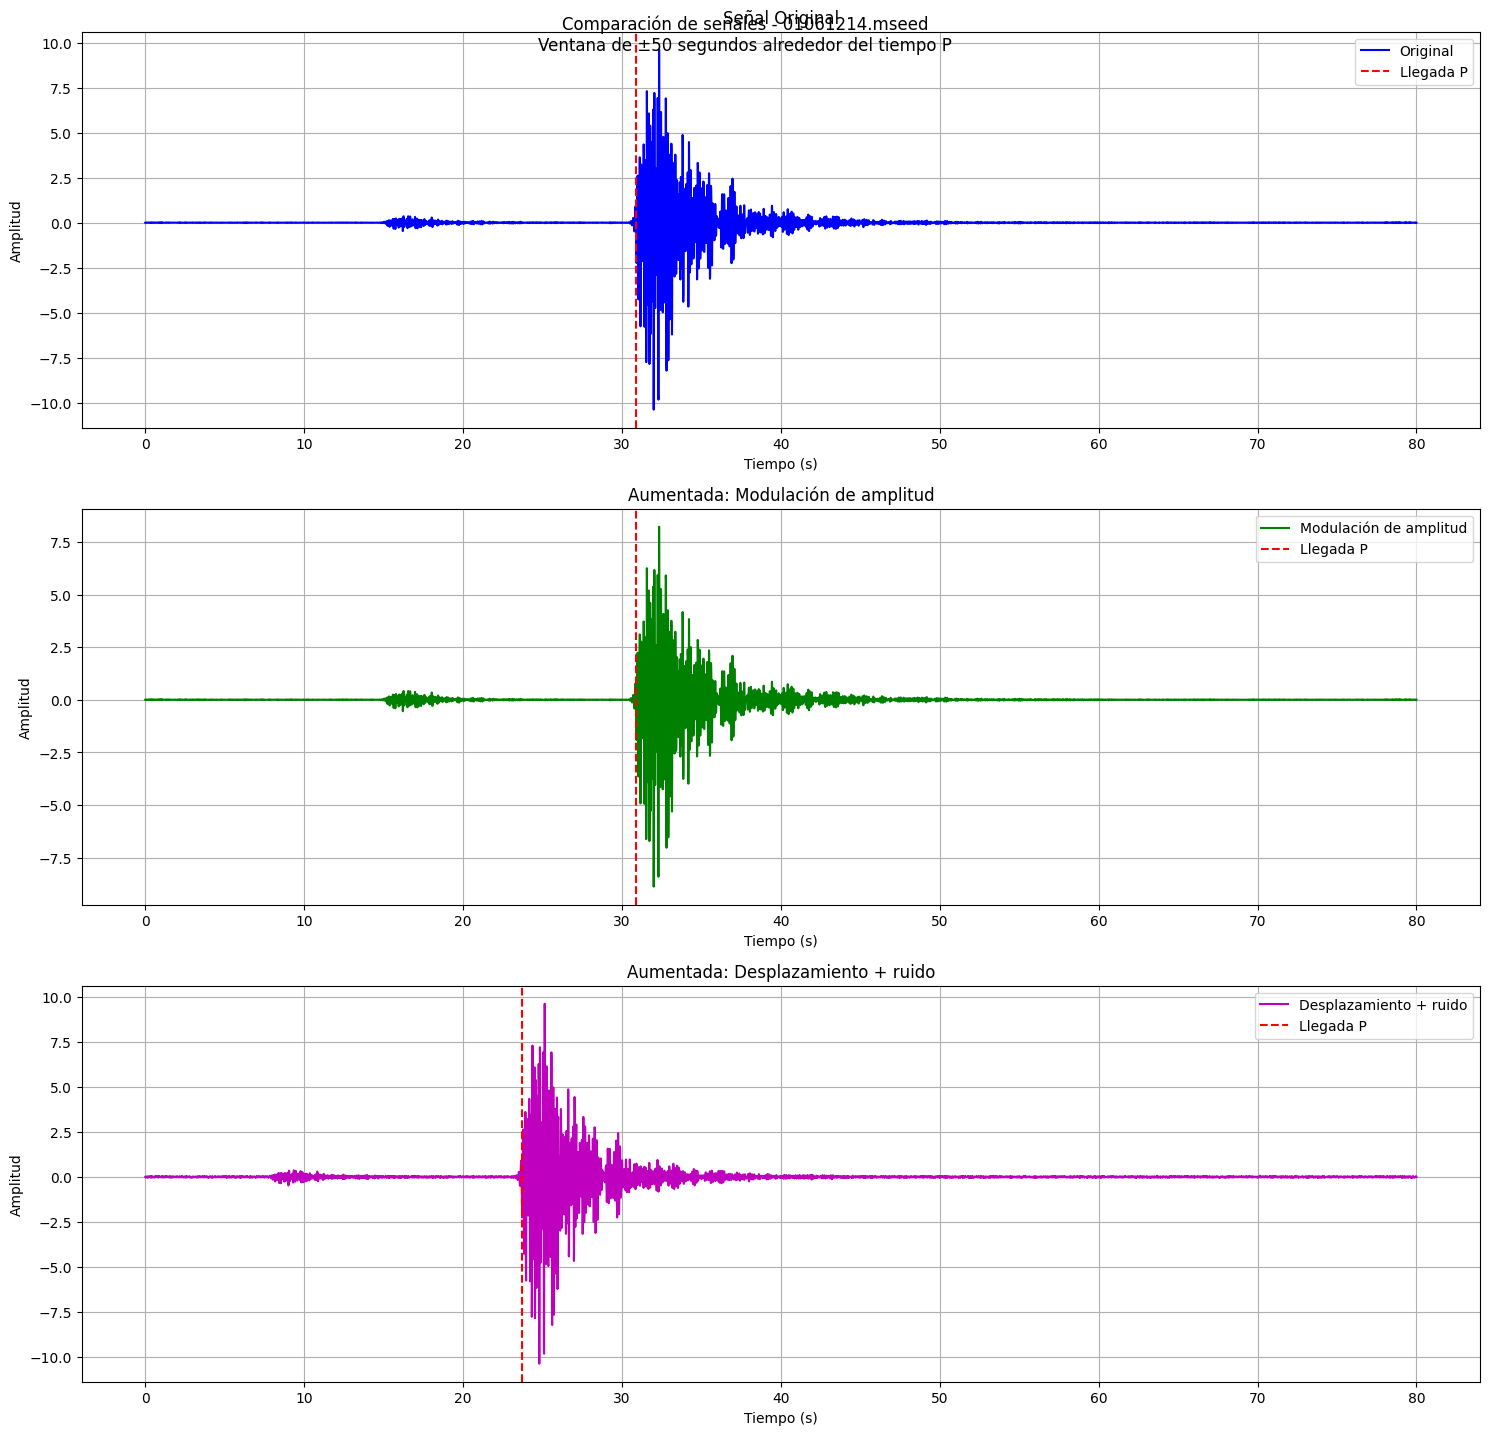


Estadísticas de las señales:
Original:
  Media: 0.000
  Desviación estándar: 0.734
  Tiempo P: 30.90 s

Modulación de amplitud:
  Media: 0.000
  Desviación estándar: 0.629
  Tiempo P: 30.90 s

Desplazamiento + ruido:
  Media: -0.000
  Desviación estándar: 0.734
  Tiempo P: 23.70 s
  Desplazamiento: -7.20 s

Rango de tiempo mostrado: 0.0s - 80.0s
Duración total mostrada: 80.0s

Creadas 2 versiones aumentadas


In [50]:
# Probar con un archivo de ejemplo
example_file = '01061214.mseed'
example_row = df[df['archivo'] == int(example_file[:8])]

# aplicar data augmented a todos los arhivos y guardar el tiempo de llegada de cada archivo en csv 
if not example_row.empty:
    p_time = example_row.iloc[0]['lec_p']
    print(f"Procesando archivo: {example_file}")
    
    # Leer la señal para obtener el tiempo relativo
    st = read(os.path.join(train_data_path, example_file))
    relative_p_time = get_relative_p_time(st[0], p_time)
    print(f"Tiempo de llegada de onda P relativo: {relative_p_time:.2f} segundos")
    
    # Generar y visualizar las señales aumentadas
    plot_augmentation_comparison(example_file)
    
    # Guardar las señales aumentadas
    num_augmented = augment_single_file(example_file, p_time)
    print(f"\nCreadas {num_augmented} versiones aumentadas")
else:
    print("Archivo no encontrado en el CSV")

Procesando archivo: 04010355.mseed
Tiempo de llegada de onda P relativo: 9.07 segundos


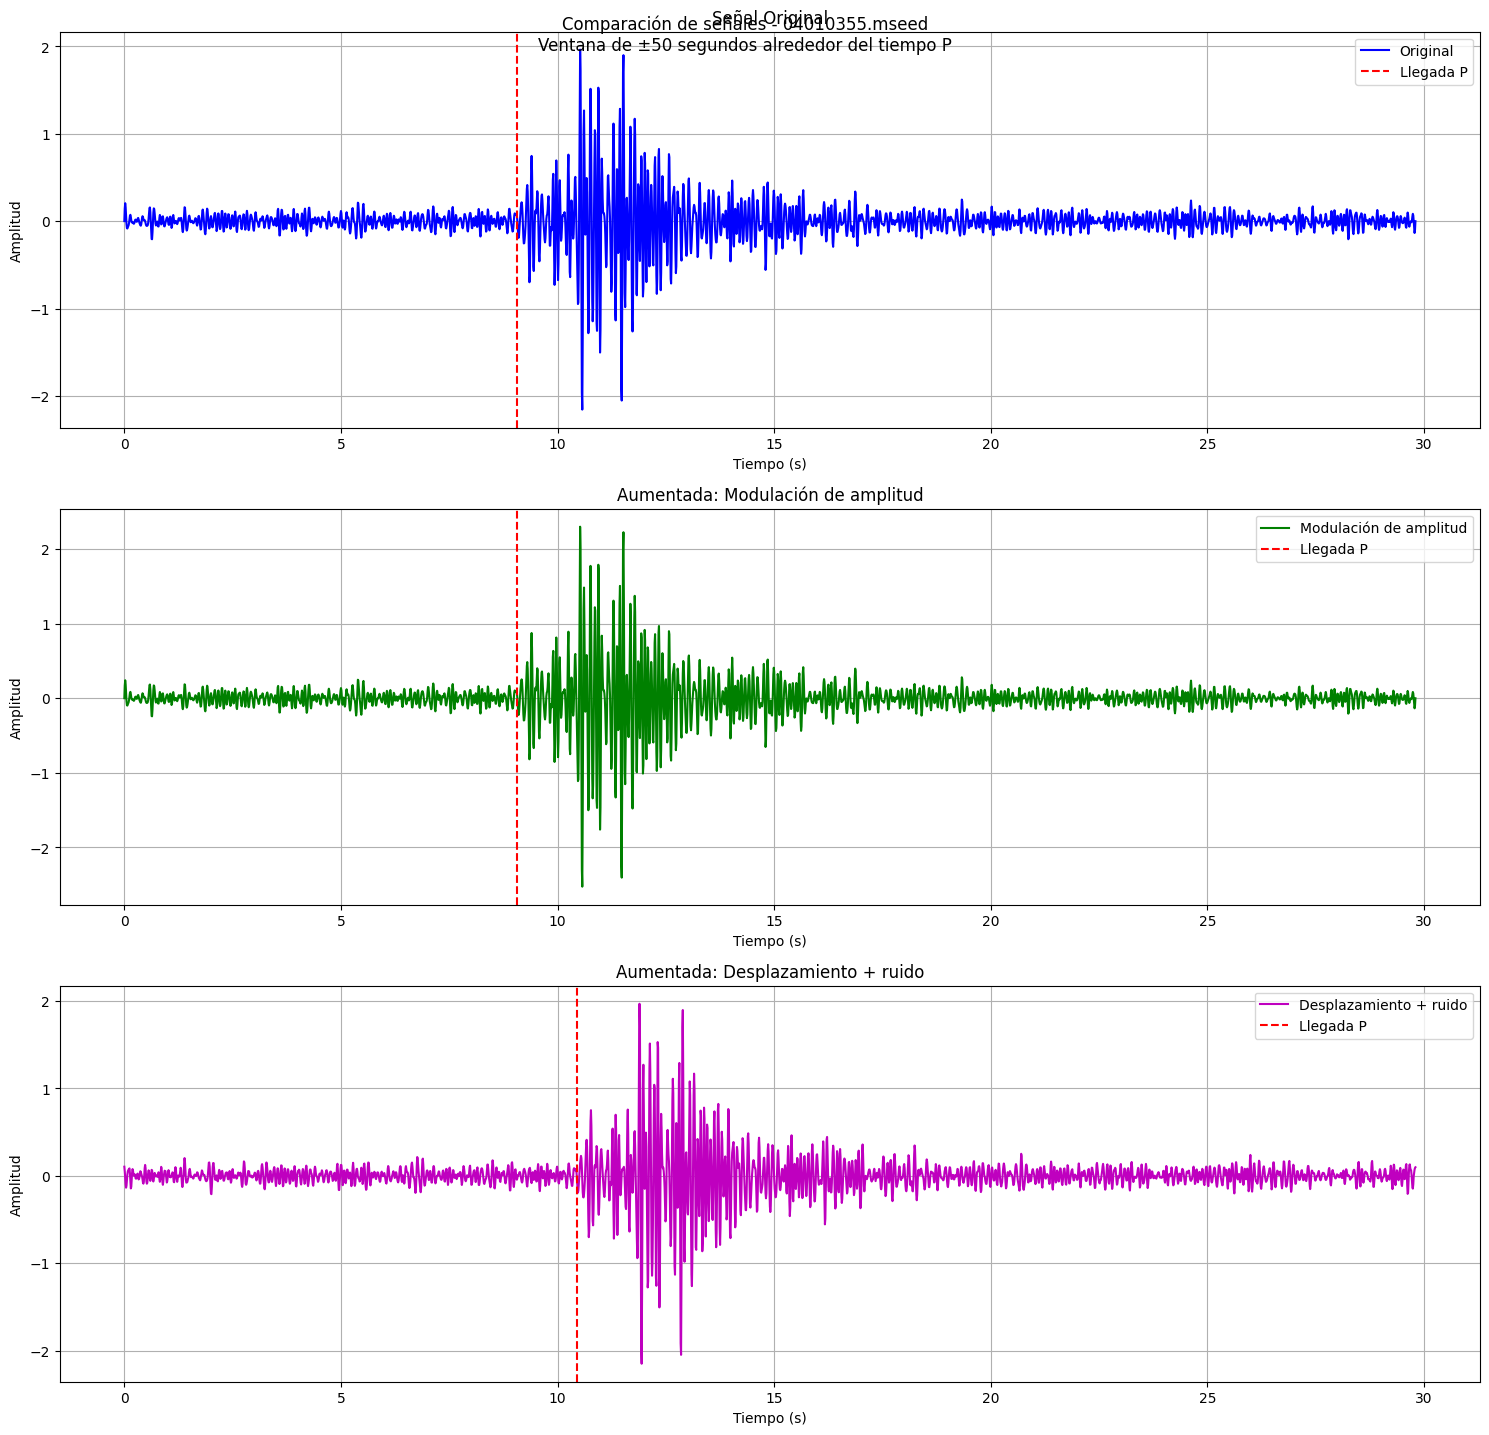


Estadísticas de las señales:
Original:
  Media: 0.000
  Desviación estándar: 0.233
  Tiempo P: 9.07 s

Modulación de amplitud:
  Media: 0.000
  Desviación estándar: 0.272
  Tiempo P: 9.07 s

Desplazamiento + ruido:
  Media: -0.000
  Desviación estándar: 0.233
  Tiempo P: 10.44 s
  Desplazamiento: 1.37 s

Rango de tiempo mostrado: 0.0s - 29.8s
Duración total mostrada: 29.8s

Creadas 2 versiones aumentadas


In [51]:
# Probar con un archivo de ejemplo
example_file = '04010355.mseed'
example_row = df[df['archivo'] == int(example_file[:8])]

# aplicar data augmented a todos los arhivos y guardar el tiempo de llegada de cada archivo en csv 
if not example_row.empty:
    p_time = example_row.iloc[0]['lec_p']
    print(f"Procesando archivo: {example_file}")
    
    # Leer la señal para obtener el tiempo relativo
    st = read(os.path.join(train_data_path, example_file))
    relative_p_time = get_relative_p_time(st[0], p_time)
    print(f"Tiempo de llegada de onda P relativo: {relative_p_time:.\2f} segundos")
    
    # Generar y visualizar las señales aumentadas
    plot_augmentation_comparison(example_file)
    
    # Guardar las señales aumentadas
    num_augmented = augment_single_file(example_file, p_time)
    print(f"\nCreadas {num_augmented} versiones aumentadas")
else:
    print("Archivo no encontrado en el CSV")

In [15]:
# function to move the files 

files = os.listdir(train_data_path)

def copy_files(df, source_path, dest_path):
    """
    Move files from source_path to dest_path based on the filenames in the dataframe.	
    """
    for index, row in df.iterrows():
        filename = row['filename']
        source_file = os.path.join(source_path, filename + '.mseed')
        dest_file = os.path.join(dest_path, filename + '.mseed')
        if os.path.exists(source_file):
            shutil.copy2(source_file, dest_file)
            print(f'Moved {source_file} to {dest_file}')
        else:
            print(f'File {source_file} does not exist')

df = pd.DataFrame(files, columns=['filename'])
df['filename'] = df['filename'].str.replace('.mseed', '') 
train_set, test_set = train_test_split(df, test_size=0.16, random_state=42)


In [ ]:
copy_files(train_set, train_data_path, train_augment_data_path)

In [29]:
files_val = os.listdir(val_data_path)
print(f"Total files in val_data_path: {len(files_val)}")
files_training = os.listdir(train_data_path)
print(f"Total files in train_data_path: {len(files_training)}")
files_testing = os.listdir(testing_data_path)
print(f"Total files in augmented_data_path: {len(files_testing)}")
files_augmented = os.listdir(train_augment_data_path)
print(f"Total files in augmented_data_path: {len(files_augmented)}")

Total files in val_data_path: 317
Total files in train_data_path: 1980
Total files in augmented_data_path: 496
Total files in augmented_data_path: 1663


In [ ]:
files_arrival_times = os.listdir(train_augment_data_path_2)
print(f"Total files in augmented_data_path: {len(files_arrival_times)}")



In [ ]:
# Procesamiento v1 de los datos aumentados, con shift aleatorio y ruido 
def process_all_files():
    # Prepare dataframe to store arrival times
    columns = ['original_file', 'augmented_file', 'arrival_time', 'augmentation_type']
    arrival_times_df = pd.DataFrame(columns=columns)

    # Get list of files in training directory
    train_files = [f for f in os.listdir(train_augment_data_path) if f.endswith('.mseed')]

    print(f"Processing {len(train_files)} files...")

    for mseed_file in tqdm(train_files):
        # Get original file ID and lookup P arrival time
        file_id = int(mseed_file.split('.')[0])
        row = df[df['archivo'] == file_id]

        if not row.empty:
            p_time = row.iloc[0]['lec_p']
            
            # Read original signal
            st = read(os.path.join(train_augment_data_path, mseed_file))
            relative_p_time = get_relative_p_time(st[0], p_time)
            
            # Store original file info
            base_name = os.path.splitext(mseed_file)[0]
            arrival_times_df = pd.concat([arrival_times_df, pd.DataFrame([{
                'original_file': mseed_file,
                'augmented_file': mseed_file,
                'arrival_time': relative_p_time,
                'augmentation_type': 'original'
            }])], ignore_index=True)
            
            # Generate augmented signals with their respective arrival times
            augmented_signals, augmented_arrivals = augment_seismic_data(
                st[0].data,
                st[0].stats.sampling_rate,
                relative_p_time
            )
            
            # Generate and save augmented signals
            for i, (aug_signal, aug_arrival) in enumerate(zip(augmented_signals, augmented_arrivals)):
                aug_st = st.copy()
                aug_st[0].data = aug_signal
                aug_filename = f"{base_name}_aug{i+1}.mseed"
                output_path = os.path.join(train_augment_data_path_2, aug_filename)
                aug_st.write(output_path, format='MSEED')
                
                aug_type = 'amplitude_modulation' if i == 0 else 'time_shift_noise'
                arrival_times_df = pd.concat([arrival_times_df, pd.DataFrame([{
                    'original_file': mseed_file,
                    'augmented_file': aug_filename,
                    'arrival_time': aug_arrival,  # Using the actual augmented arrival time
                    'augmentation_type': aug_type
                }])], ignore_index=True)

    # Save arrival times to CSV
    csv_path = os.path.join(augmented_data_path, 'arrival_times.csv')
    arrival_times_df.to_csv(csv_path, index=False)
    print(f"\nArrival times saved to {csv_path}")
    return arrival_times_df

arrival_times_df = process_all_files()
# Print the first few rows of the DataFrame
print(arrival_times_df.head())



Processing 1663 files...


  0%|          | 0/1663 [00:00<?, ?it/s]/tmp/ipykernel_2593/2942974162.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  arrival_times_df = pd.concat([arrival_times_df, pd.DataFrame([{
  0%|          | 1/1663 [00:00<03:15,  8.49it/s]/tmp/ipykernel_2593/2942974162.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  arrival_times_df = pd.concat([arrival_times_df, pd.DataFrame([{
100%|██████████| 1663/1663 [00:57<00:00, 29.01it/s] 




Arrival times saved to /mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training_augmented/arrival_times.csv
    original_file       augmented_file  arrival_time     augmentation_type
0  01010056.mseed       01010056.mseed          30.6              original
1  01010056.mseed  01010056_aug1.mseed          30.6  amplitude_modulation
2  01010056.mseed  01010056_aug2.mseed          21.0      time_shift_noise
3  01010332.mseed       01010332.mseed          30.1              original
4  01010332.mseed  01010332_aug1.mseed          30.1  amplitude_modulation


In [ ]:
# copy original files to augmented data 
copy_files(train_set, train_augment_data_path, train_augment_data_path_2)

In [18]:
filses_augmented = os.listdir(train_augment_data_path_2)
print(f"Total files in augmented_data_path: {len(filses_augmented)}")
files_training = os.listdir(train_augment_data_path)
print(f"Total files in train_augment_data_path: {len(files_training)}")

Total files in augmented_data_path: 4989
Total files in train_augment_data_path: 1663


In [ ]:
# --- Aumentar señales para que el arrival_time esté en (1, 20) segundos SOLO para archivos seleccionados del set de entrenamiento ---
def augment_to_target_arrival_time(mseed_file, absolute_p_time, target_range=(1, 20), n_versions=3):
    """Genera versiones aumentadas de una señal con arrival_time en el rango target_range.
    Args:
        mseed_file: nombre del archivo .mseed
        absolute_p_time: tiempo absoluto de llegada P
        target_range: tupla (min, max) en segundos
        n_versions: cuántas versiones generar
    Returns:
        lista de (filename, new_arrival_time)
    """
    file_path = os.path.join(train_data_path, mseed_file)
    st = read(file_path)
    tr = st[0]
    start_time = tr.stats.starttime.timestamp
    relative_p_time = absolute_p_time - start_time
    sample_rate = tr.stats.sampling_rate
    results = []
    for i in range(n_versions):
        # Elegir un arrival_time objetivo aleatorio en el rango
        target_p = np.random.uniform(*target_range)
        # Calcular el shift necesario (en muestras)
        shift_samples = int((target_p - relative_p_time) * sample_rate)
        # Limitar el shift para no salir del arreglo
        max_left = -int(relative_p_time * sample_rate)
        max_right = len(tr.data) - int(relative_p_time * sample_rate)
        shift_samples = np.clip(shift_samples, max_left, max_right)
        # Aplicar shift
        shifted = np.roll(tr.data, shift_samples)
        # Agregar un poco de ruido para evitar duplicados exactos
        shifted = add_noise(shifted, noise_level=0.02)
        # Guardar archivo
        base_name = os.path.splitext(mseed_file)[0]
        out_name = f"{base_name}_targetP_{i+1}.mseed"
        out_path = os.path.join(train_augment_data_path_2, out_name)
        st_aug = st.copy()
        st_aug[0].data = shifted
        st_aug.write(out_path, format='MSEED')
        results.append((out_name, target_p))
    return results


selected_train_files = [
    '01010056.mseed',
    '01010332.mseed',
    '01010543.mseed'
]

arrival_times_target = []
for fname in selected_train_files:
    file_id = int(fname.split('.')[0])
    row = df[df['archivo'] == file_id]
    if not row.empty:
        abs_p = row.iloc[0]['lec_p']
        augmented = augment_to_target_arrival_time(fname, abs_p, target_range=(1, 20), n_versions=3)
        for out_name, new_p in augmented:
            arrival_times_target.append({
                'original_file': fname,
                'augmented_file': out_name,
                'arrival_time': new_p,
                'augmentation_type': 'target_arrival_time_(1,20)'
            })
    else:
        print(f"No se encontró arrival_time para {fname}")

# --- Guardar los nuevos arrival_times en un CSV adicional ---
if arrival_times_target:
    df_target = pd.DataFrame(arrival_times_target)
    csv_target = os.path.join(augmented_data_path, 'arrival_times_target_1_20_selected.csv')
    df_target.to_csv(csv_target, index=False)
    print(f"Arrival times (target 1-20s, selected) guardados en: {csv_target}")
else:
    print("No se generaron señales aumentadas para el rango objetivo.")

Arrival times (target 1-20s, selected) guardados en: /mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training_augmented/arrival_times_target_1_20_selected.csv


>Ver que el shift y la modificación en la amplitud en la honda se esta aplicando correctamente 

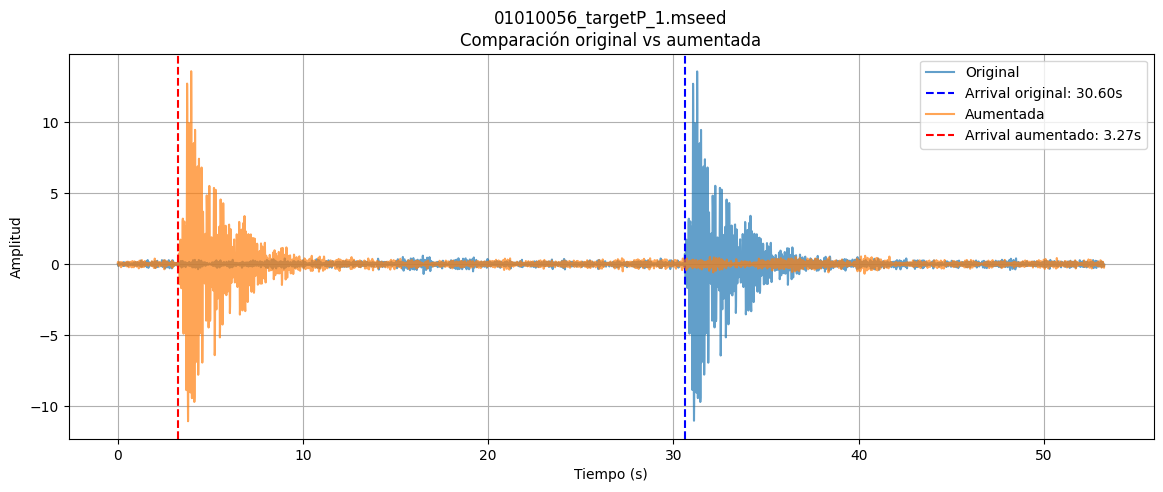

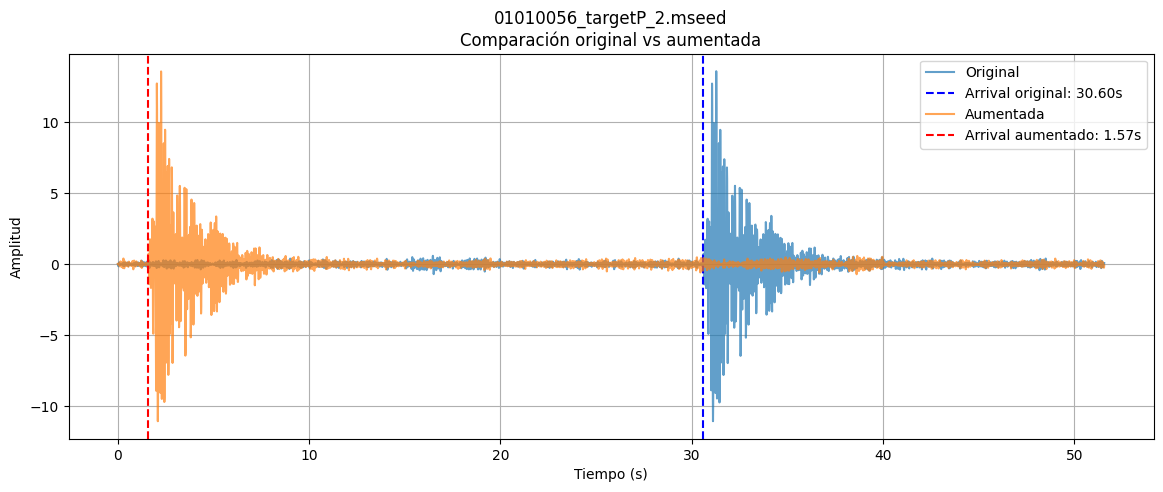

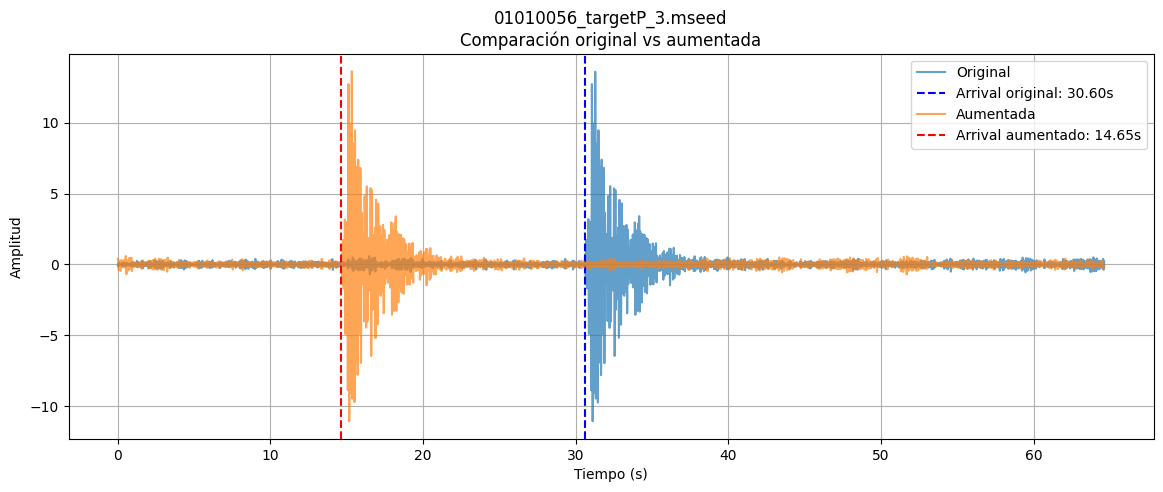

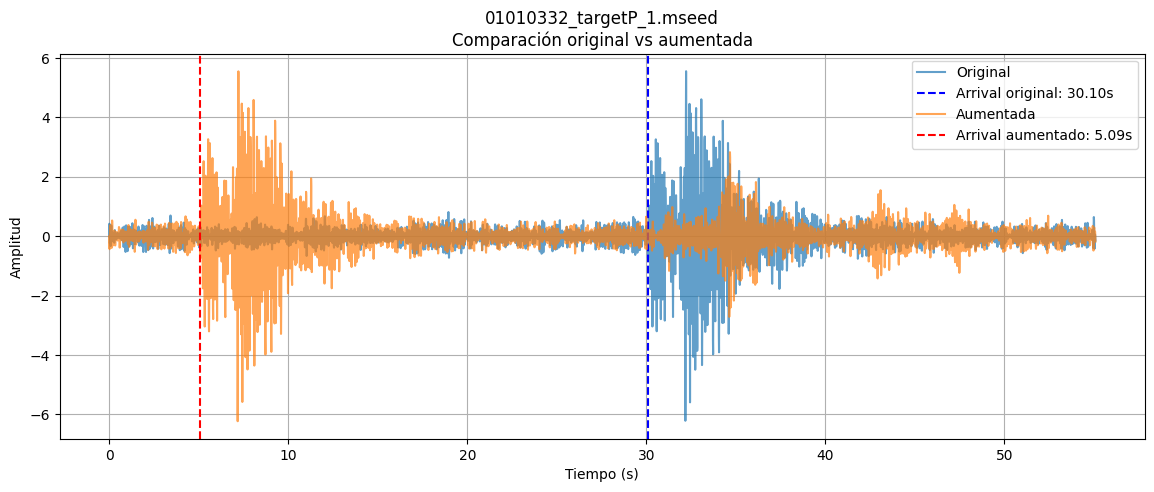

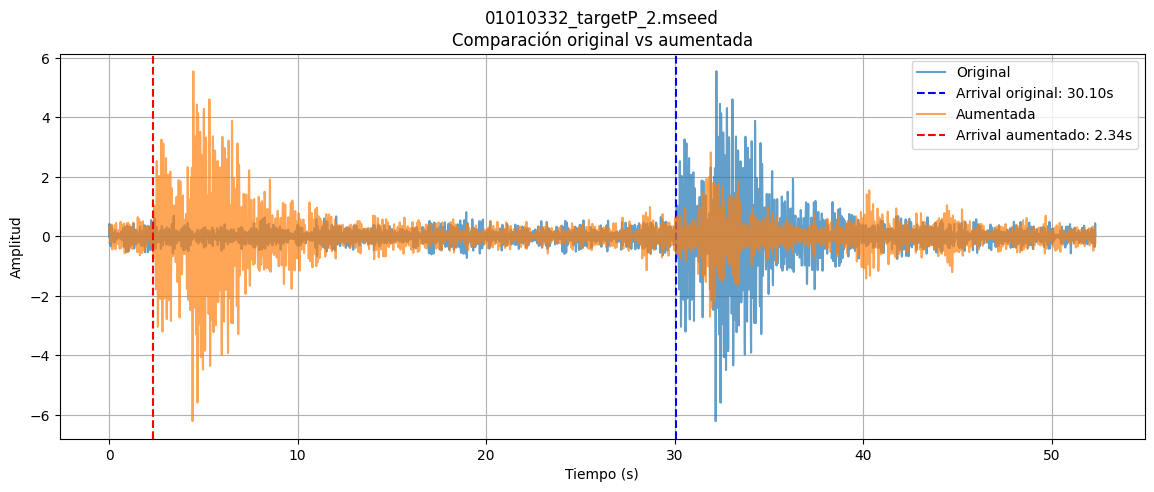

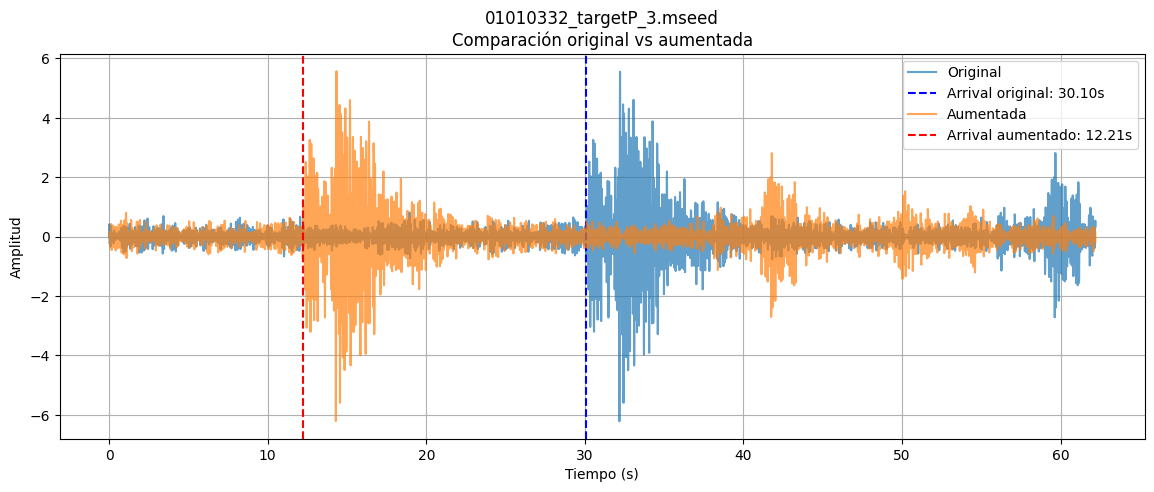

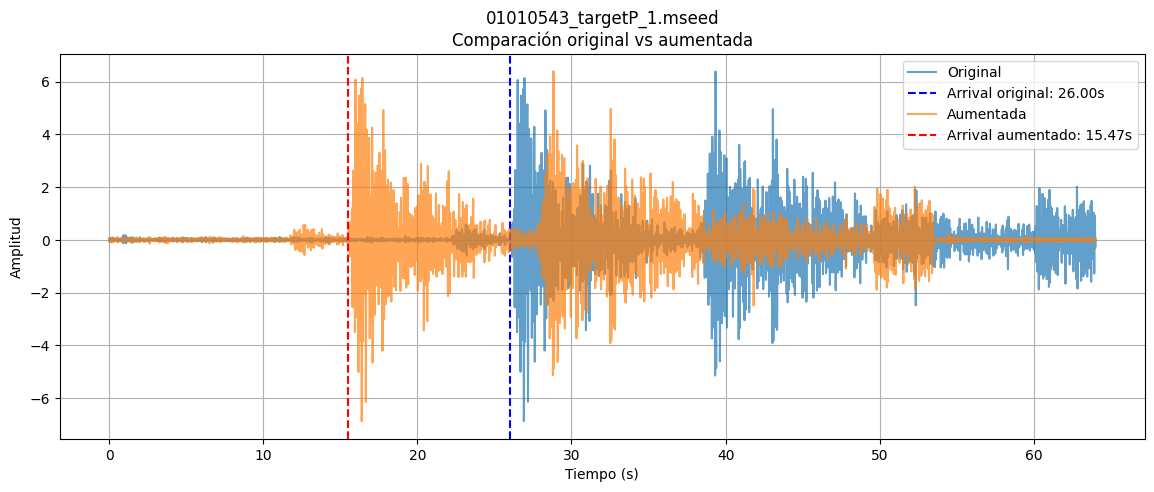

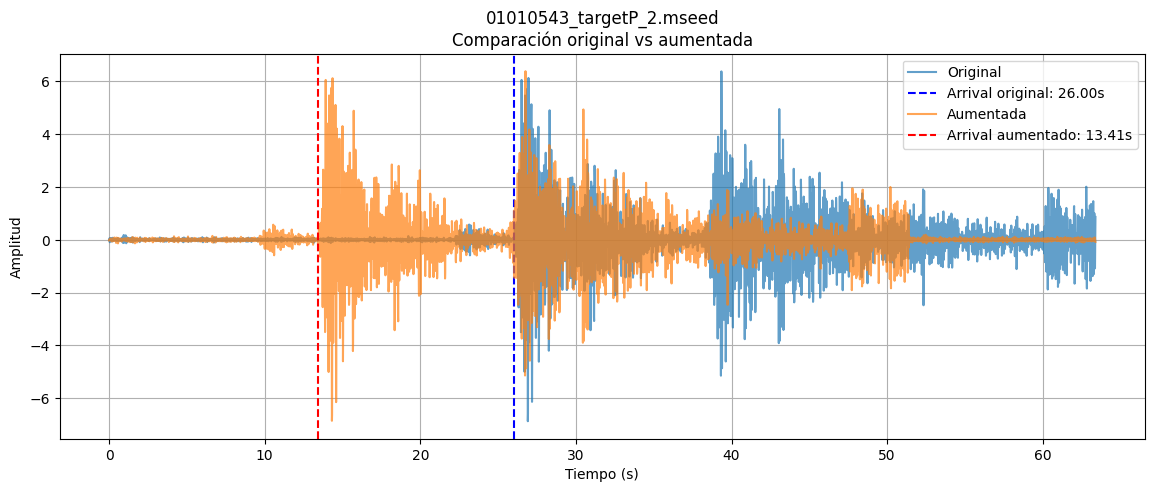

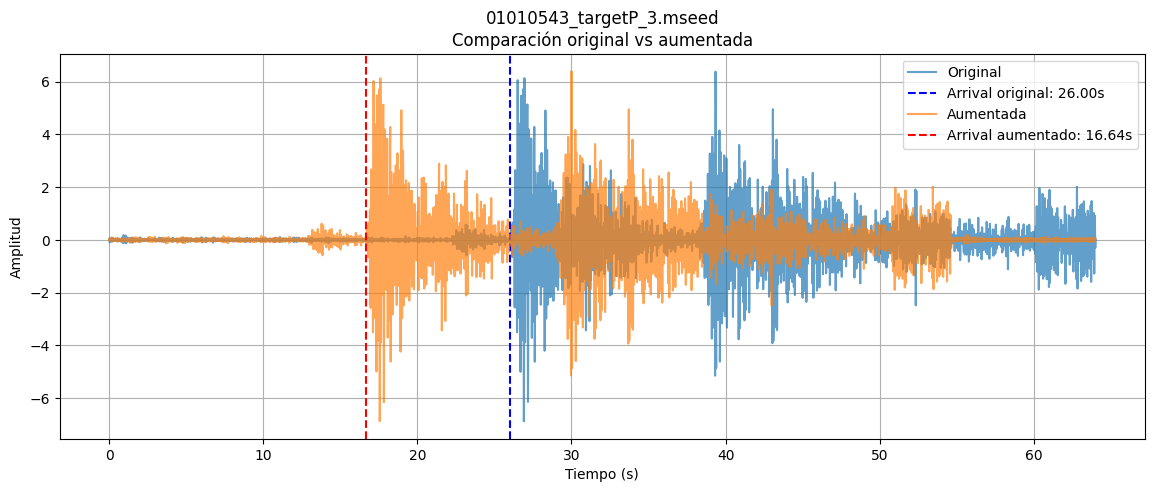

In [ ]:
# --- Visualizar las señales originales y aumentadas con arrival_time específico ---
csv_target = os.path.join(augmented_data_path, 'arrival_times_target_1_20_selected.csv')
df_target = pd.read_csv(csv_target)

def plot_original_vs_augmented(row):
    """Grafica la señal original y la aumentada con arrival_time específico."""
    # Archivo aumentado
    aug_file_path = os.path.join(train_augment_data_path_2, row['augmented_file'])
    st_aug = read(aug_file_path)
    tr_aug = st_aug[0]
    times_aug = np.arange(len(tr_aug.data)) / tr_aug.stats.sampling_rate
    p_time_aug = row['arrival_time']

    # Archivo original
    orig_file_path = os.path.join(train_data_path, row['original_file'])
    st_orig = read(orig_file_path)
    tr_orig = st_orig[0]
    times_orig = np.arange(len(tr_orig.data)) / tr_orig.stats.sampling_rate

    # Buscar arrival_time original absoluto y relativo
    file_id = int(row['original_file'].split('.')[0])
    orig_row = df[df['archivo'] == file_id]
    if orig_row.empty:
        print(f"No se encontró arrival_time para {row['original_file']}")
        return
    abs_p = orig_row.iloc[0]['lec_p']
    rel_p = abs_p - tr_orig.stats.starttime.timestamp

    # Ventana de visualización
    window = 50
    start_idx = max(0, int((p_time_aug - window) * tr_aug.stats.sampling_rate))
    end_idx = min(len(times_aug), int((p_time_aug + window) * tr_aug.stats.sampling_rate))

    plt.figure(figsize=(14, 5))
    # Señal original
    plt.plot(times_orig[start_idx:end_idx], tr_orig.data[start_idx:end_idx], label='Original', alpha=0.7)
    plt.axvline(x=rel_p, color='b', linestyle='--', label=f'Arrival original: {rel_p:.2f}s')
    # Señal aumentada
    plt.plot(times_aug[start_idx:end_idx], tr_aug.data[start_idx:end_idx], label='Aumentada', alpha=0.7)
    plt.axvline(x=p_time_aug, color='r', linestyle='--', label=f'Arrival aumentado: {p_time_aug:.2f}s')
    plt.title(f"{row['augmented_file']}\nComparación original vs aumentada")
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualizar todas las señales originales y aumentadas del CSV
for idx, row in df_target.iterrows():
    plot_original_vs_augmented(row)

In [ ]:
train_augment_data_ranges_path = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training_augmented/augmented_ranges'

# Versión de prueba para el aumento de datos por rangos 
def augment_two_ranges_test(mseed_file, absolute_p_time, range1=(1, 20), range2=(35, 50), noise_level=0.01):
    """Genera dos versiones aumentadas con arrival_times en rangos diferentes.
    Para señales cortas usa augment_seismic_data como fallback.

    Args:
        mseed_file: nombre del archivo .mseed
        absolute_p_time: tiempo absoluto de llegada P
        range1: tupla (min, max) en segundos para primera versión
        range2: tupla (min, max) en segundos para segunda versión
        noise_level: nivel de ruido gaussiano a añadir
    Returns:
        lista de tuplas (augmented_filename, new_arrival_time)
    """
    file_path = os.path.join(train_data_path, mseed_file)
    st = read(file_path)
    tr = st[0]
    start_time = tr.stats.starttime.timestamp
    relative_p_time = absolute_p_time - start_time
    sample_rate = tr.stats.sampling_rate
    results = []

    # Guardar archivo original en carpeta de rangos
    original_out_path = os.path.join(train_augment_data_ranges_path, mseed_file)
    st.write(original_out_path, format='MSEED')

    total_duration = len(tr.data) / sample_rate
    min_signal_length = max(range2[1], 35) + 5  # Mínimo 55s para rangos largos

    if total_duration < min_signal_length:
        print(f"{mseed_file} demasiado corto ({total_duration:.2f}s), usando augment_seismic_data.")
        # Usar augment_seismic_data como fallback
        augmented_signals, augmented_arrivals = augment_seismic_data(
            tr.data,
            tr.stats.sampling_rate,
            relative_p_time
        )
        
        # Guardar las señales aumentadas
        base_name = os.path.splitext(mseed_file)[0]
        for i, (aug_signal, aug_arrival) in enumerate(zip(augmented_signals, augmented_arrivals)):
            aug_st = st.copy()
            aug_st[0].data = aug_signal
            aug_filename = f"{base_name}_aug{i+1}.mseed"
            output_path = os.path.join(train_augment_data_ranges_path, aug_filename)
            aug_st.write(output_path, format='MSEED')
            results.append((aug_filename, aug_arrival))
        
        return results

    # Aplicar aumentos por rangos para señales largas
    ranges = [(range1, '1_20'), (range2, '35_50')]
    for range_tuple, range_id in ranges:
        target_p = np.random.uniform(*range_tuple)
        shift_samples = int((target_p - relative_p_time) * sample_rate)
        current_index = int(relative_p_time * sample_rate)

        max_left = -current_index
        max_right = len(tr.data) - current_index

        if shift_samples < max_left or shift_samples > max_right:
            print(f"Rango {range_id} no viable para {mseed_file}. Shift requerido: {shift_samples}, límites: ({max_left}, {max_right})")
            continue

        shifted = np.roll(tr.data, shift_samples)
        shifted = amplitude_modulation(shifted)
        shifted_noisy = add_noise(shifted, noise_level=noise_level)

        base_name = os.path.splitext(mseed_file)[0]
        out_name = f"{base_name}_aug{range_id}.mseed"
        out_path = os.path.join(train_augment_data_ranges_path, out_name)

        aug_st = st.copy()
        aug_st[0].data = shifted_noisy
        aug_st.write(out_path, format='MSEED')
        
        # El nuevo tiempo de llegada es el objetivo (target_p)
        results.append((out_name, target_p))

    return results

test_files = [
    '01010056.mseed',
    '01010332.mseed',
    '10011901.mseed',
    '04010355.mseed',
]

results_two_ranges = []
for fname in test_files:
    file_id = int(fname.split('.')[0])
    row = df[df['archivo'] == file_id]
    if not row.empty:
        abs_p = row.iloc[0]['lec_p']
        augmented = augment_two_ranges_test(fname, abs_p)
        for out_name, new_p in augmented:
            results_two_ranges.append({
                'original_file': fname,
                'augmented_file': out_name,
                'arrival_time': new_p,
                'augmentation_type': 'time_shift_amplify_35_50'
            })

# Guardar resultados
if results_two_ranges:
    df_ranges = pd.DataFrame(results_two_ranges)
    csv_ranges = os.path.join(augmented_data_path, 'arrival_times_ranges.csv')
    df_ranges.to_csv(csv_ranges, index=False)
    print(f"Arrival times guardados en: {csv_ranges}")


04010355.mseed demasiado corto (29.81s), usando augment_seismic_data.
Arrival times guardados en: /mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training_augmented/arrival_times_ranges.csv


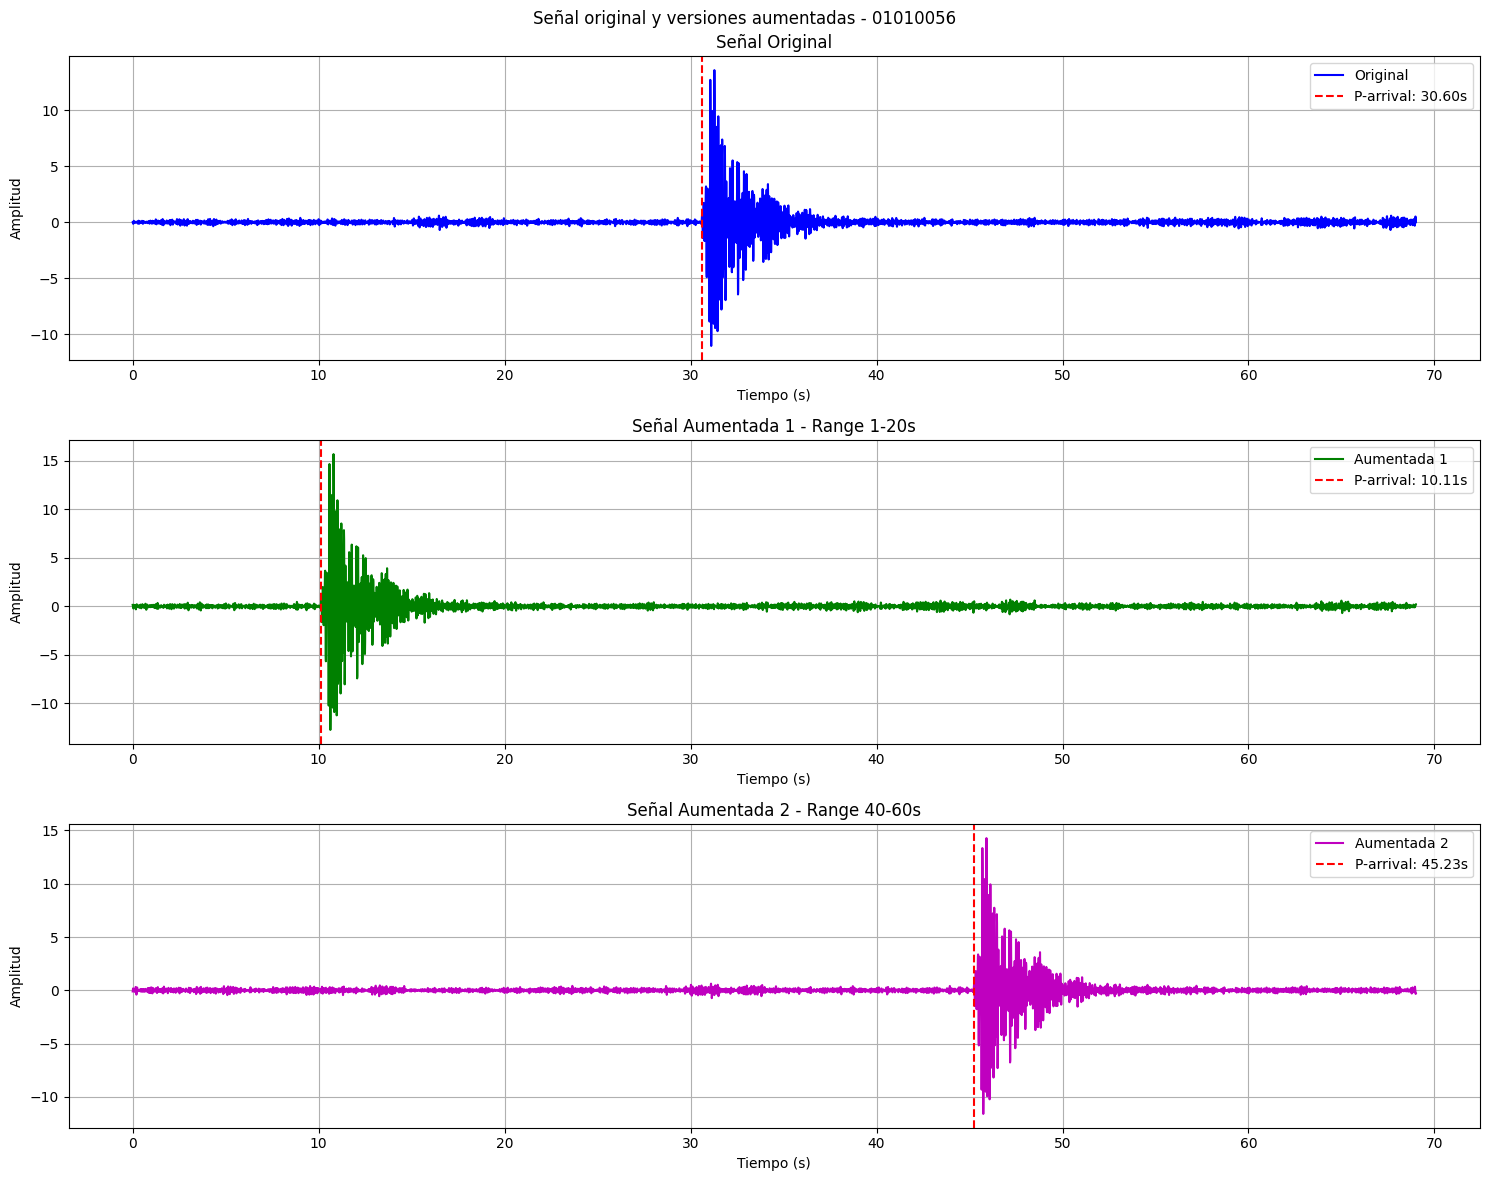


Estadísticas para 01010056.mseed:
            augmented_file  arrival_time
0   01010056_aug1_20.mseed     10.112934
1  01010056_aug35_50.mseed     45.231045


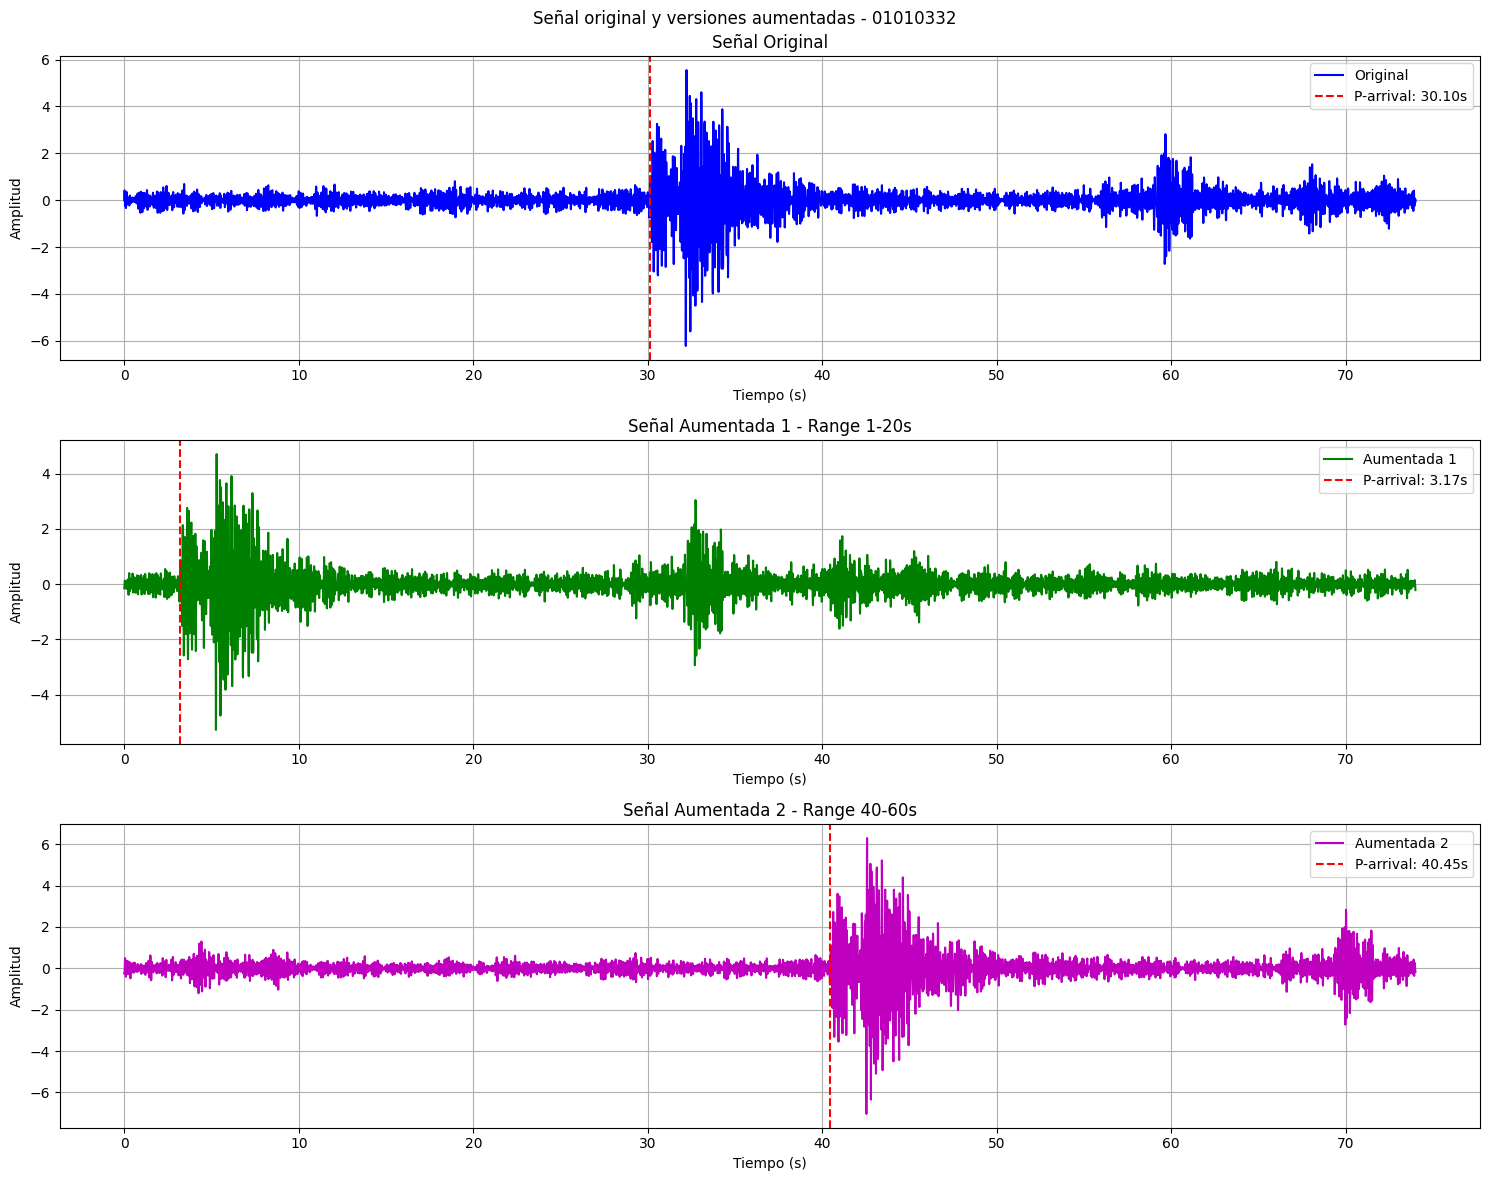


Estadísticas para 01010332.mseed:
            augmented_file  arrival_time
2   01010332_aug1_20.mseed      3.166814
3  01010332_aug35_50.mseed     40.454891


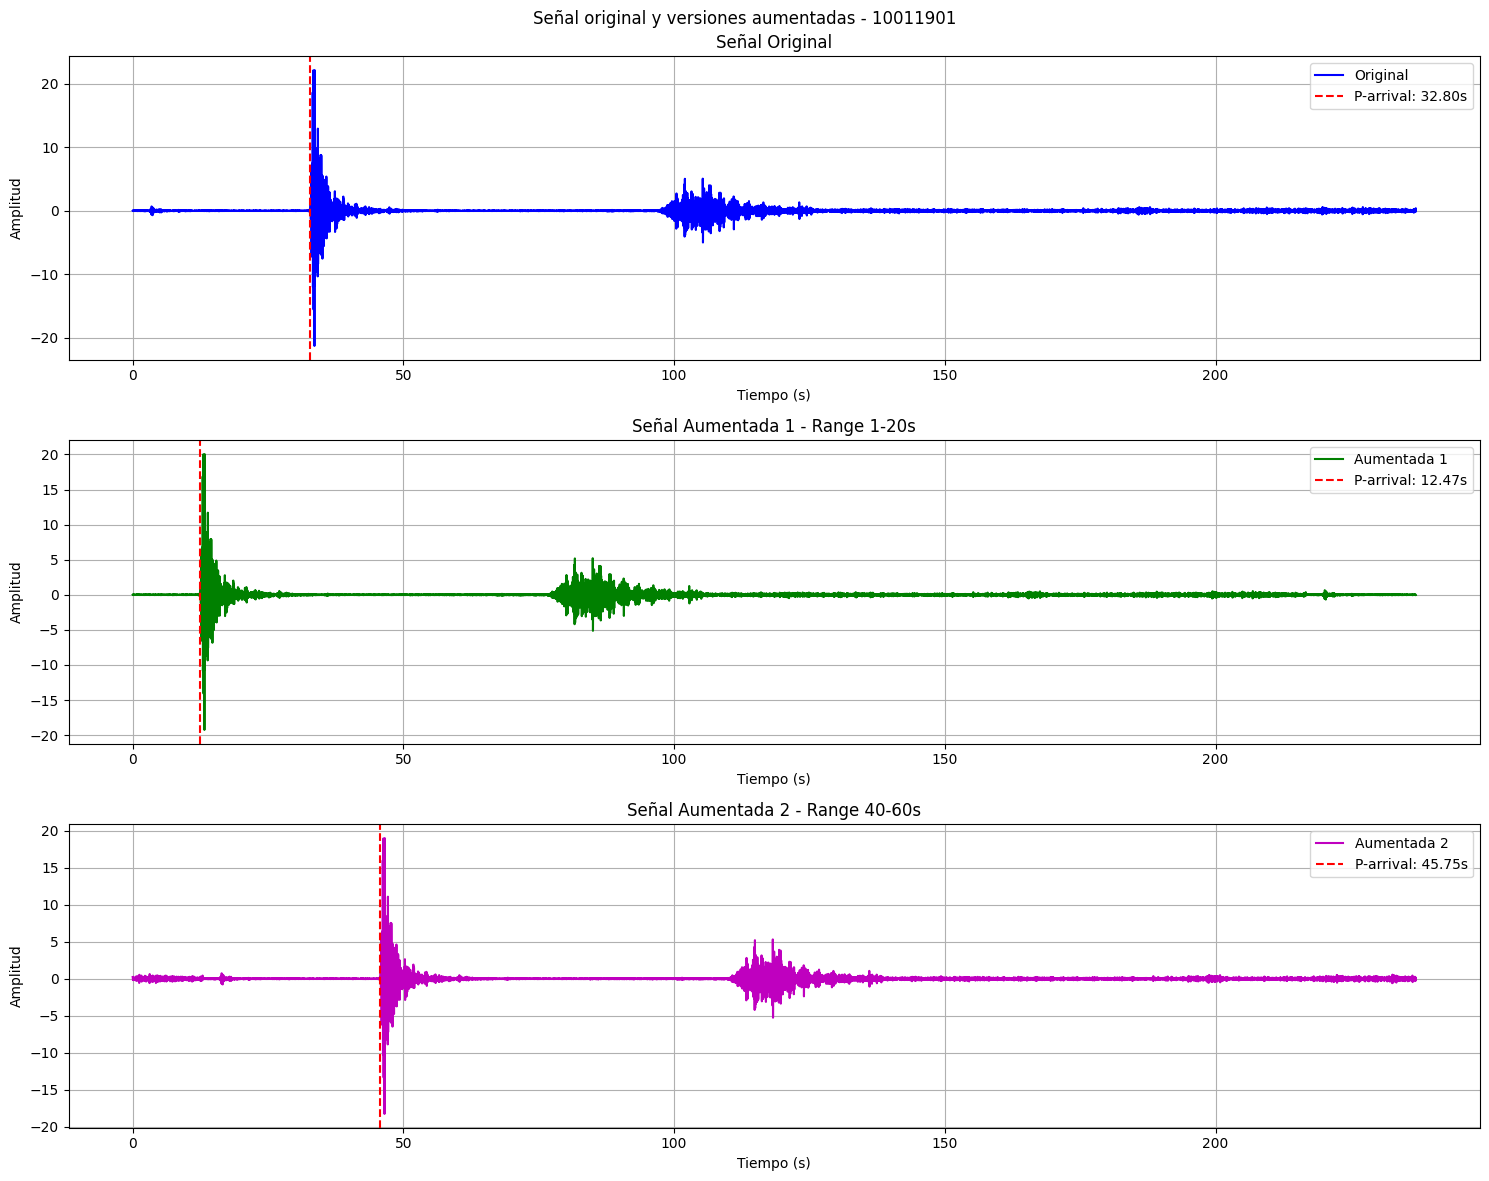


Estadísticas para 10011901.mseed:
            augmented_file  arrival_time
4   10011901_aug1_20.mseed     12.472188
5  10011901_aug35_50.mseed     45.747938


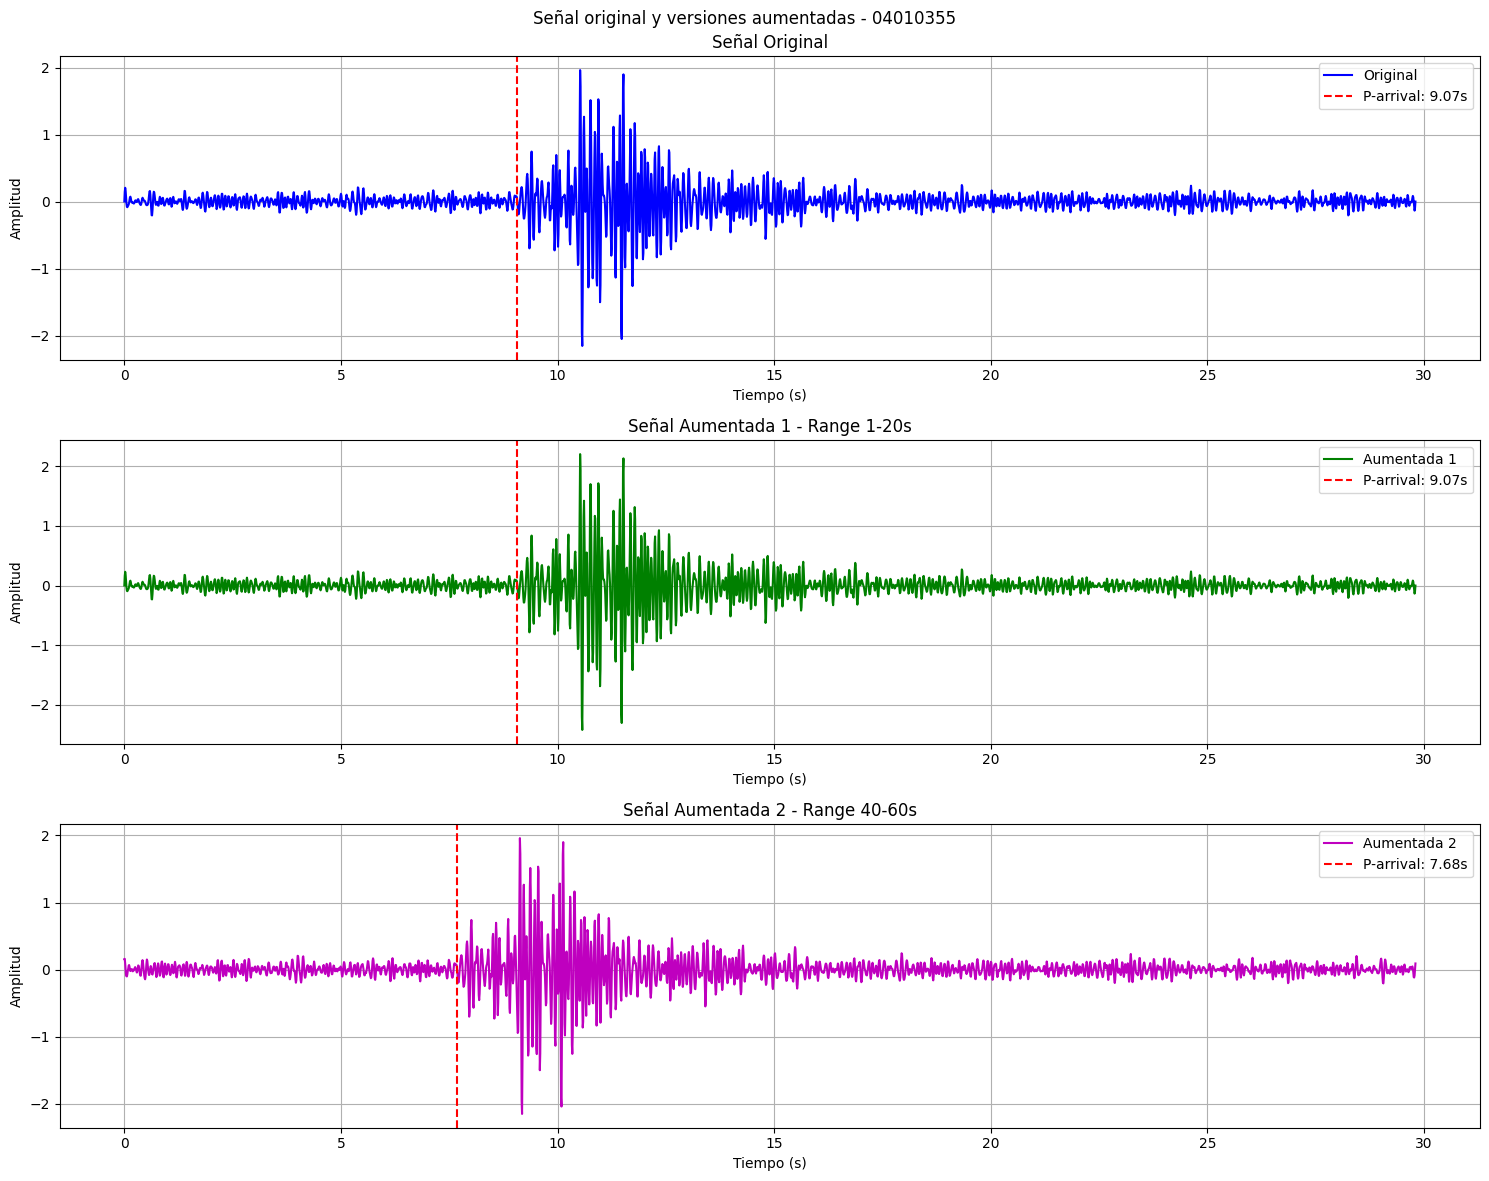


Estadísticas para 04010355.mseed:
        augmented_file  arrival_time
6  04010355_aug1.mseed      9.070006
7  04010355_aug2.mseed      7.680006


In [ ]:
def plot_original_and_augmented_ranges(base_filename):
    """Visualiza la señal original y sus dos versiones aumentadas con diferentes rangos.
    Args:
        base_filename: Nombre del archivo base sin extensión"""
    # Leer señal original
    orig_file = f"{base_filename}.mseed"
    orig_path = os.path.join(train_data_path, orig_file)
    st_orig = read(orig_path)
    tr_orig = st_orig[0]
    times_orig = np.arange(len(tr_orig.data)) / tr_orig.stats.sampling_rate

    # Obtener P-arrival time original
    file_id = int(base_filename)
    orig_row = df[df['archivo'] == file_id]
    if orig_row.empty:
        print(f"No se encontró arrival_time para {base_filename}")
        return
    abs_p = orig_row.iloc[0]['lec_p']
    rel_p = abs_p - tr_orig.stats.starttime.timestamp

    # Leer señales aumentadas
    augmented_info = df_ranges[df_ranges['original_file'] == orig_file]
    if len(augmented_info) != 2:
        print(f"No se encontraron las dos versiones aumentadas para {base_filename}")
        return

    # Configurar subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
    fig.suptitle(f'Señal original y versiones aumentadas - {base_filename}')

    # Graficar señal original
    ax1.plot(times_orig, tr_orig.data, 'b-', label='Original')
    ax1.axvline(x=rel_p, color='r', linestyle='--', label=f'P-arrival: {rel_p:.2f}s')
    ax1.set_title('Señal Original')
    ax1.grid(True)
    ax1.legend()

    # Graficar señales aumentadas
    for idx, (_, row) in enumerate(augmented_info.iterrows(), 1):
        aug_path = os.path.join(train_augment_data_ranges_path, row['augmented_file'])
        st_aug = read(aug_path)
        tr_aug = st_aug[0]
        times_aug = np.arange(len(tr_aug.data)) / tr_aug.stats.sampling_rate
        ax = ax2 if idx == 1 else ax3
        ax.plot(times_aug, tr_aug.data, 'g-' if idx == 1 else 'm-', label=f'Aumentada {idx}')
        ax.axvline(x=row['arrival_time'], color='r', linestyle='--', 
                  label=f'P-arrival: {row["arrival_time"]:.2f}s')
        ax.set_title(f'Señal Aumentada {idx} - Range {"1-20s" if idx == 1 else "40-60s"}')
        ax.grid(True)
        ax.legend()

    for ax in (ax1, ax2, ax3):
        ax.set_xlabel('Tiempo (s)')
        ax.set_ylabel('Amplitud')

    plt.tight_layout()
    plt.show()

# Visualizar los resultados para cada archivo de prueba
for fname in test_files:
    base_name = fname.split('.')[0]
    plot_original_and_augmented_ranges(base_name)
    print(f"\nEstadísticas para {fname}:")
    info = df_ranges[df_ranges['original_file'] == fname]
    print(info[['augmented_file', 'arrival_time']])
    

>Se identificarion ciertas hondas problematicas, ya sea por su corta duración en tiempo o su gran longitud para ser tratadas mediente la función de aumento de datos por rangos, y realizar las respectivas validaciones de casos especificos problematicos

## Pre-Signal Analysis

Before applying data augmentation, we will analyze the signs to:
1. Verify their length and suitability for travel
2. Calculate what percentage is usable
3. Identify problematic signs

100%|██████████| 1980/1980 [01:51<00:00, 17.82it/s] 




Estadísticas de señales:
Total señales analizadas: 1980
Duración promedio: 72.83s
Duración mínima: 29.81s
Duración máxima: 237.01s

Señales adecuadas para cada rango:
Rango 1-20s: 99.6%
Rango 40-60s: 0.0%
Ambos rangos: 0.0%


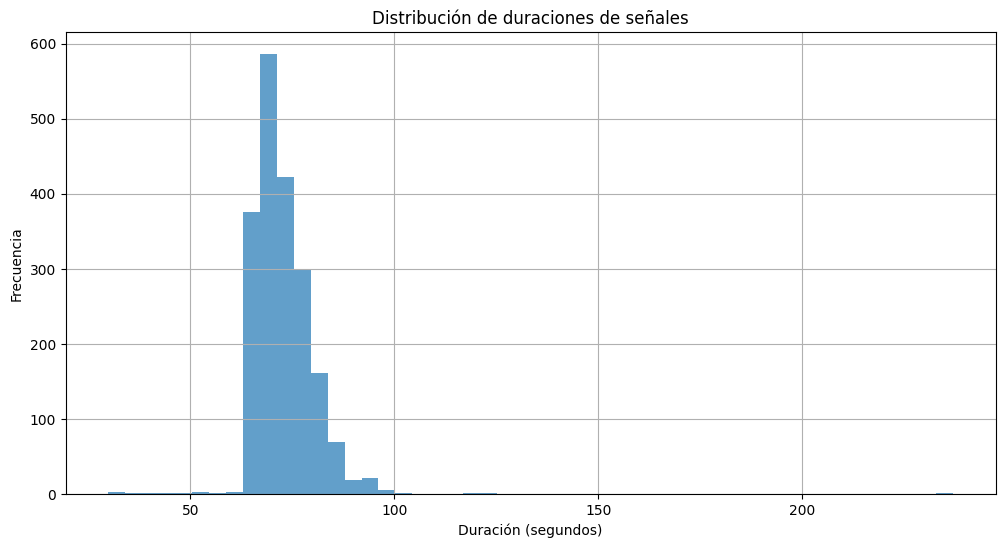


Lista de 0 archivos adecuados guardada en: /mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training_augmented/suitable_files.txt


In [6]:
def analyze_signal_suitability(files, sample_rate=100):
    """Analiza señales para determinar su adecuación para el aumento de datos.
    Args:
        files: Lista de archivos .mseed a analizar
        sample_rate: Tasa de muestreo esperada
    Returns:
        DataFrame con análisis de señales
    """
    analysis = []
    
    for fname in tqdm.tqdm(files):
        try:
            # Leer señal
            file_path = os.path.join(train_data_path, fname)
            st = read(file_path)
            tr = st[0]
            
            # Obtener tiempo P
            file_id = int(fname.split('.')[0])
            row = df[df['archivo'] == file_id]
            if row.empty:
                continue
                
            abs_p = row.iloc[0]['lec_p']
            rel_p = abs_p - tr.stats.starttime.timestamp
            duration = len(tr.data) / sample_rate
            
            # Verificar márgenes disponibles
            margin_before = rel_p  # tiempo antes del P-arrival
            margin_after = duration - rel_p  # tiempo después del P-arrival
            
            # Evaluar adecuación para cada rango
            suitable_1_20 = margin_before >= 1 and margin_after >= 20
            suitable_40_60 = margin_before >= 40 and margin_after >= 60
            
            analysis.append({
                'file': fname,
                'duration': duration,
                'p_arrival': rel_p,
                'margin_before': margin_before,
                'margin_after': margin_after,
                'suitable_1_20': suitable_1_20,
                'suitable_40_60': suitable_40_60,
                'suitable_both': suitable_1_20 and suitable_40_60
            })
        except Exception as e:
            print(f"Error procesando {fname}: {str(e)}")
    
    return pd.DataFrame(analysis)

# Analizar todas las señales del conjunto de entrenamiento
train_files = [f for f in os.listdir(train_data_path) if f.endswith('.mseed')]
df_analysis = analyze_signal_suitability(train_files)

# Mostrar estadísticas generales
print("\nEstadísticas de señales:")
print(f"Total señales analizadas: {len(df_analysis)}")
print(f"Duración promedio: {df_analysis['duration'].mean():.2f}s")
print(f"Duración mínima: {df_analysis['duration'].min():.2f}s")
print(f"Duración máxima: {df_analysis['duration'].max():.2f}s")

print("\nSeñales adecuadas para cada rango:")
print(f"Rango 1-20s: {df_analysis['suitable_1_20'].mean()*100:.1f}%")
print(f"Rango 40-60s: {df_analysis['suitable_40_60'].mean()*100:.1f}%")
print(f"Ambos rangos: {df_analysis['suitable_both'].mean()*100:.1f}%")

# Visualizar distribución de duraciones
plt.figure(figsize=(12, 6))
plt.hist(df_analysis['duration'], bins=50, alpha=0.7)
plt.title('Distribución de duraciones de señales')
plt.xlabel('Duración (segundos)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Guardar lista de archivos adecuados
suitable_files = df_analysis[df_analysis['suitable_both']]['file'].tolist()
suitable_files_path = os.path.join(augmented_data_path, 'suitable_files.txt')
with open(suitable_files_path, 'w') as f:
    f.write('\n'.join(suitable_files))

print(f"\nLista de {len(suitable_files)} archivos adecuados guardada en: {suitable_files_path}")



In [26]:
# Que archivo tiene la mayor duración de honda 
longest_duration_file = df_analysis.loc[df_analysis['duration'].idxmax()]
print(f"\nArchivo con mayor duración: {longest_duration_file['file']}")
print(f"Duración: {longest_duration_file['duration']:.2f}s")

# Que archivo tiene el menor duración de honda 
shortest_duration_file = df_analysis.loc[df_analysis['duration'].idxmin()]
print(f"\nArchivo con menor duración: {shortest_duration_file['file']}")
print(f"Duración: {shortest_duration_file['duration']:.2f}s")


Archivo con mayor duración: 10011901.mseed
Duración: 237.01s

Archivo con menor duración: 04010355.mseed
Duración: 29.81s


## Adaptive Augmentation Strategy

Based on the signal analysis, we will implement an adaptive strategy:

1. For short signals (< 40 s):
- Use only small offsets (±15%)
- Keep the P time close to the original
- Focus on amplitude modulation and noise

2. For medium signals (40-80 s):
- Allow offsets in the 1-20 s range
- Apply more aggressive amplitude modulation

3. For long signals (> 80 s):
- Use full ranges (1-30 s and 25-60 s)
- Maximum flexibility in transformations

4. Quality Validation:
- Verify SNR before/after
- Maintain P wave characteristics
- Document applied transformations

In [ ]:
def augment_two_ranges(mseed_file, absolute_p_time, range1=(1, 25), range2=(35, 60), noise_level=0.01):
    """Genera dos versiones aumentadas con arrival_times en rangos diferentes.
    Args:
        mseed_file: nombre del archivo .mseed
        absolute_p_time: tiempo absoluto de llegada P
        range1: tupla (min, max) en segundos para primera versión
        range2: tupla (min, max) en segundos para segunda versión
        noise_level: nivel de ruido gaussiano a añadir
    Returns:
        lista de tuplas (augmented_filename, new_arrival_time)
    """
    file_path = os.path.join(train_data_path, mseed_file)
    st = read(file_path)
    tr = st[0]
    # Obtener P-arrival time relativo
    start_time = tr.stats.starttime.timestamp
    relative_p_time = absolute_p_time - start_time
    sample_rate = tr.stats.sampling_rate
    results = []
    
    # Aplicar aumentos por rangos
    ranges = [(range1, '1_20'), (range2, '35_50')]
    for range_tuple, range_id in ranges:
        # Generar tiempo objetivo dentro del rango especificado
        target_p = np.random.uniform(range_tuple[0], range_tuple[1])
        shift_samples = int((target_p - relative_p_time) * sample_rate)
        
        # Generar señal aumentada
        shifted = np.roll(tr.data, shift_samples)
        shifted = amplitude_modulation(shifted)
        shifted_noisy = add_noise(shifted, noise_level=noise_level)
        
        # Guardar señal aumentada
        base_name = os.path.splitext(mseed_file)[0]
        out_name = f"{base_name}_aug_{range_id}.mseed"
        out_path = os.path.join(train_augment_data_ranges_path, out_name)
        
        aug_st = st.copy()
        aug_st[0].data = shifted_noisy
        aug_st.write(out_path, format='MSEED')
        
        results.append((out_name, target_p))
        
    return results

In [ ]:
# Función para procesar todos los archivos y aplicar aumentos adaptados a su duración por rangos, y validación a archivos cortos 
def process_all_files_adaptive(input_files=None, min_duration=30, max_duration=240):
    """Procesa archivos aplicando aumentos adaptados a su duración.
    Args:
        input_files: Lista de archivos a procesar. Si es None, usa todos los archivos MSEED
        min_duration: Duración mínima aceptable en segundos
        max_duration: Duración máxima aceptable en segundos
    """
    if input_files is None:
        input_files = [f for f in os.listdir(train_data_path) if f.endswith('.mseed')]
    
    results = []
    arrival_times = []  # List to store arrival times
    skipped = []
    stats = {'short': 0, 'medium': 0, 'long': 0, 'invalid': 0}
    
    for fname in tqdm.tqdm(input_files):
        try:
            # Leer señal y verificar duración
            st = read(os.path.join(train_data_path, fname))
            tr = st[0]
            duration = len(tr.data) / tr.stats.sampling_rate
            
            # Obtener tiempo P
            file_id = int(fname.split('.')[0])
            row = df[df['archivo'] == file_id]
            if row.empty:
                stats['invalid'] += 1
                skipped.append((fname, "No se encontró tiempo P"))
                continue
            
            # Obtener tiempo P absoluto y relativo
            abs_p = row.iloc[0]['lec_p']
            rel_p = abs_p - tr.stats.starttime.timestamp
            
            # Guardar señal original y su tiempo de llegada
            original_out_path = os.path.join(train_augment_data_ranges_path, fname)
            st.write(original_out_path, format='MSEED')
            arrival_times.append({
                'original_file': fname,
                'file': fname,
                'arrival_time': rel_p,
                'augmentation_type': 'original'
            })
            
            # Aplicar estrategia según duración
            if duration < 40:  # Señales cortas
                stats['short'] += 1
                # Generar versiones aumentadas usando augment_seismic_data
                augmented_signals, augmented_arrivals = augment_seismic_data(
                    tr.data,
                    tr.stats.sampling_rate,
                    rel_p
                )
                
                # Guardar señales aumentadas y sus tiempos
                base_name = os.path.splitext(fname)[0]
                aug_types = ['amplitude_modulation', 'time_shift_noise']
                for i, (aug_signal, aug_arrival) in enumerate(zip(augmented_signals, augmented_arrivals), 1):
                    aug_filename = f"{base_name}_aug{i}.mseed"
                    aug_st = st.copy()
                    aug_st[0].data = aug_signal
                    aug_st.write(os.path.join(train_augment_data_ranges_path, aug_filename), format='MSEED')
                    arrival_times.append({
                        'original_file': fname,
                        'file': aug_filename,
                        'arrival_time': aug_arrival,
                        'augmentation_type': aug_types[i-1]
                    })
            else:  # Señales medias y largas
                if duration < 60:
                    stats['medium'] += 1
                    range1, range2 = (1, 20), (15, 25)
                else:
                    stats['long'] += 1
                    range1, range2 = (1, 30), (30, 60)
                    
                # Generar versiones con rangos específicos
                ranges = [(range1, '1_20'), (range2, '25_35')]
                base_name = os.path.splitext(fname)[0]
                
                for (range_tuple, range_id) in ranges:
                    target_p = np.random.uniform(*range_tuple)
                    aug_filename = f"{base_name}_range_{range_id}.mseed"
                    aug_st = st.copy()
                    shift_samples = int((target_p - rel_p) * tr.stats.sampling_rate)
                    shifted = np.roll(tr.data, shift_samples)
                    shifted = amplitude_modulation(shifted)
                    shifted = add_noise(shifted, noise_level=0.01)
                    aug_st[0].data = shifted
                    aug_st.write(os.path.join(train_augment_data_ranges_path, aug_filename), format='MSEED')
                    arrival_times.append({
                        'original_file': fname,
                        'file': aug_filename,
                        'arrival_time': target_p,
                        'augmentation_type': f'time_shift_range_{range_id}'
                    })

        except Exception as e:
            skipped.append((fname, str(e)))
            stats['invalid'] += 1
    
    # Guardar tiempos de llegada en CSV
    df_arrival_times = pd.DataFrame(arrival_times)
    arrival_times_path = os.path.join(augmented_data_path, 'arrival_times_all.csv')
    df_arrival_times.to_csv(arrival_times_path, index=False)
    
    print("\nEstadísticas de procesamiento:")
    print(f"Total archivos procesados: {len(input_files)}")
    print(f"Señales cortas (<40s): {stats['short']}")
    print(f"Señales medias (40-80s): {stats['medium']}")
    print(f"Señales largas (>80s): {stats['long']}")
    print(f"Archivos inválidos/omitidos: {stats['invalid']}")
    print(f"\nTiempos de llegada guardados en: {arrival_times_path}")
    
    return df_arrival_times, stats, skipped

In [174]:
# procesar todos los archivos
results_df, stats, skipped = process_all_files_adaptive()
# Mostrar resultados
print("\nResultados de procesamiento guardados en 'augmentation_results.csv'")
print(f"Archivos omitidos guardados en 'skipped_files.txt'")
# Mostrar archivos omitidos
print("\nArchivos omitidos:")
for fname, reason in skipped:
    print(f"{fname}: {reason}")

  0%|          | 0/1980 [00:00<?, ?it/s]

100%|██████████| 1980/1980 [01:47<00:00, 18.36it/s]


Estadísticas de procesamiento:
Total archivos procesados: 1980
Señales cortas (<40s): 5
Señales medias (40-80s): 7
Señales largas (>80s): 1968
Archivos inválidos/omitidos: 0

Tiempos de llegada guardados en: /mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training_augmented/arrival_times_all.csv

Resultados de procesamiento guardados en 'augmentation_results.csv'
Archivos omitidos guardados en 'skipped_files.txt'

Archivos omitidos:


In [3]:
# contar archivos en un directorio
def count_files_in_directory(directory):
    """Cuenta el número de archivos en un directorio."""
    if os.path.exists(directory):
        files = os.listdir(directory)
        return len(files)
    else:
        print(f"El directorio {directory} no existe.")
        return 0


In [146]:
train_files_count = count_files_in_directory(train_data_path)
print(f"Total de archivos en {train_data_path}: {train_files_count}")

Total de archivos en /mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training: 1980


In [7]:
test_original_path = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/raw/train'
train_files_count = count_files_in_directory(test_original_path)
print(f"Total de archivos en {test_original_path}: {train_files_count}")

Total de archivos en /mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/raw/train: 2500


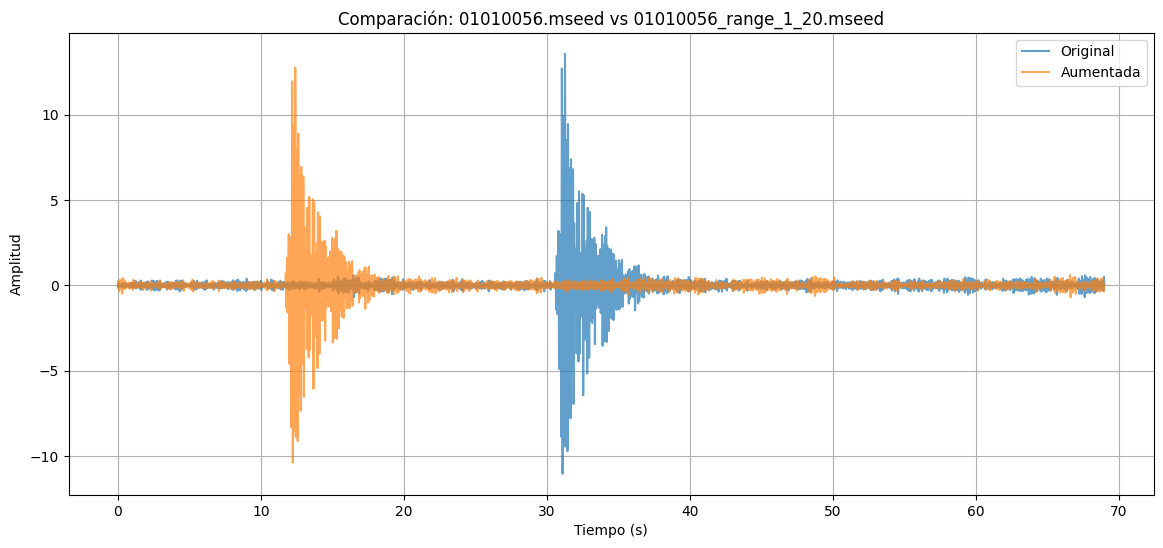

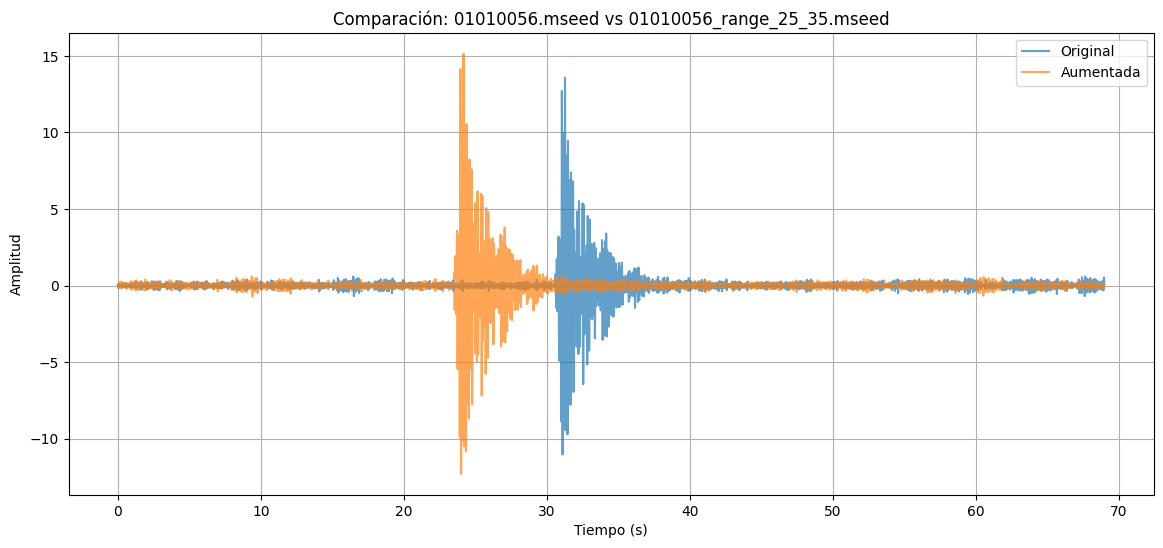

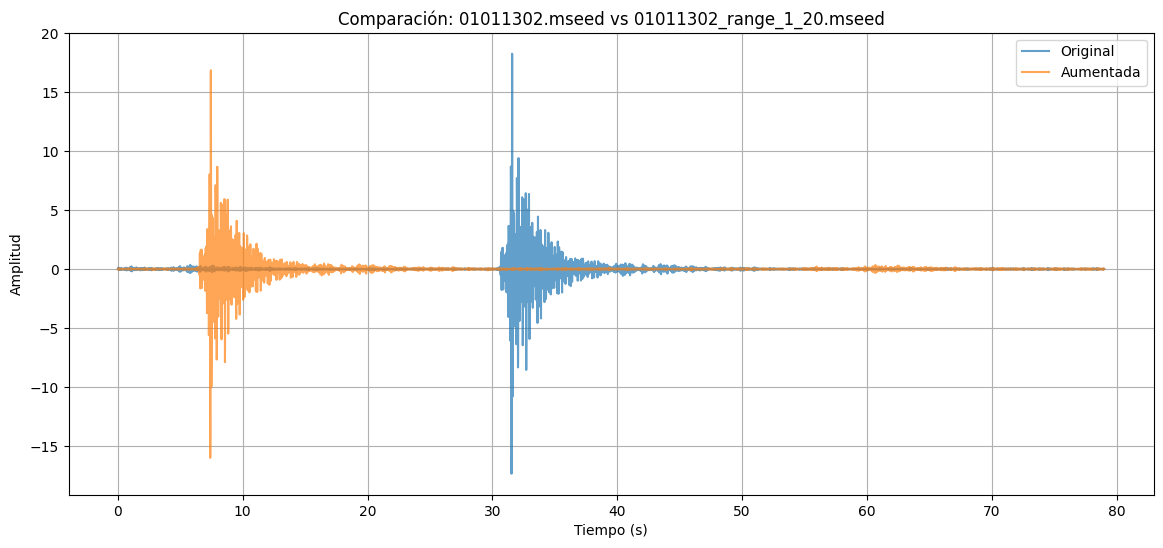

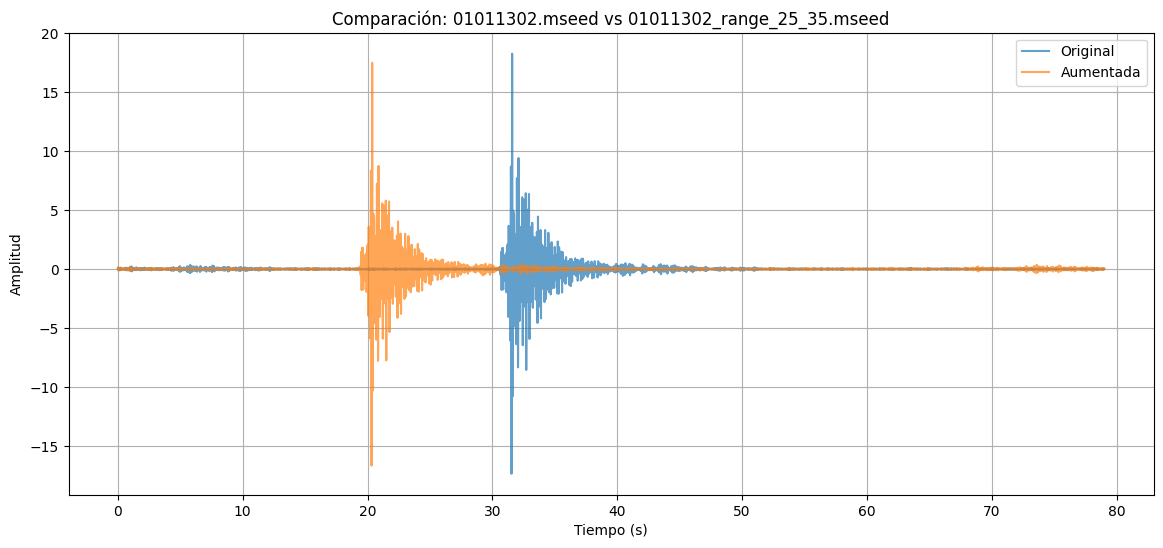

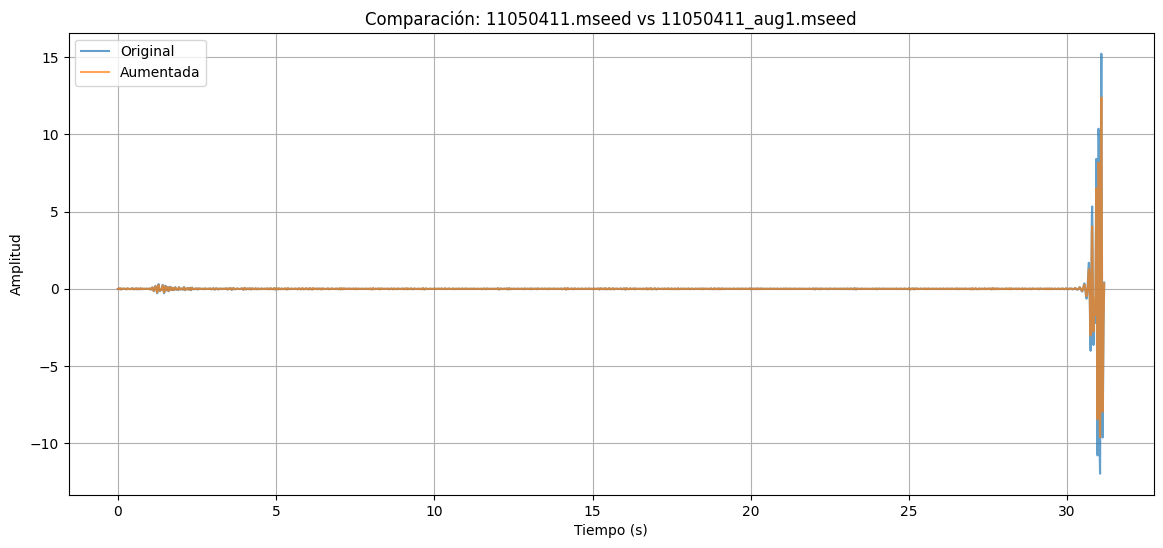

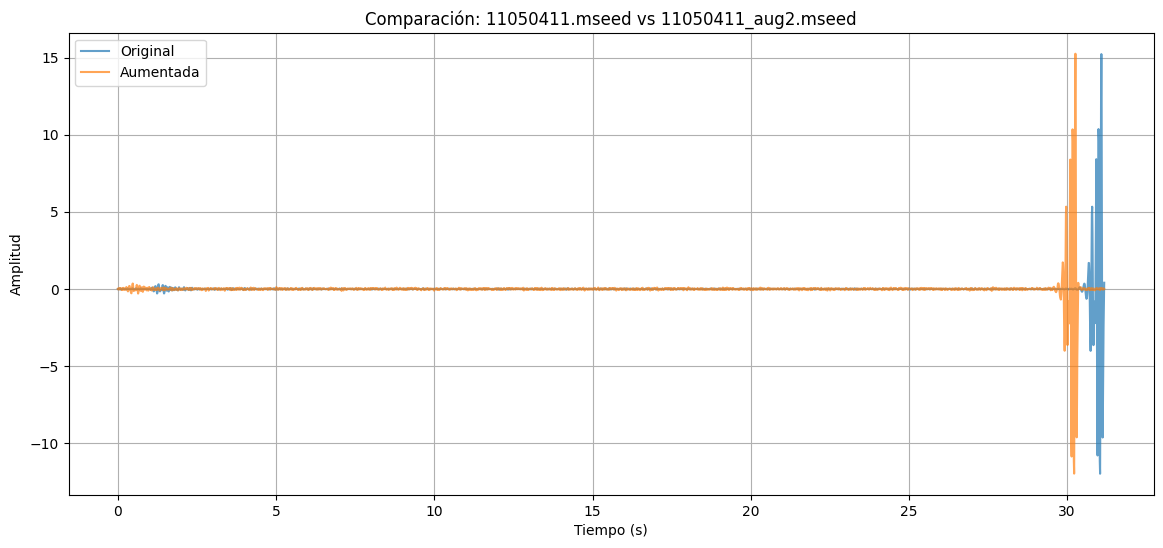

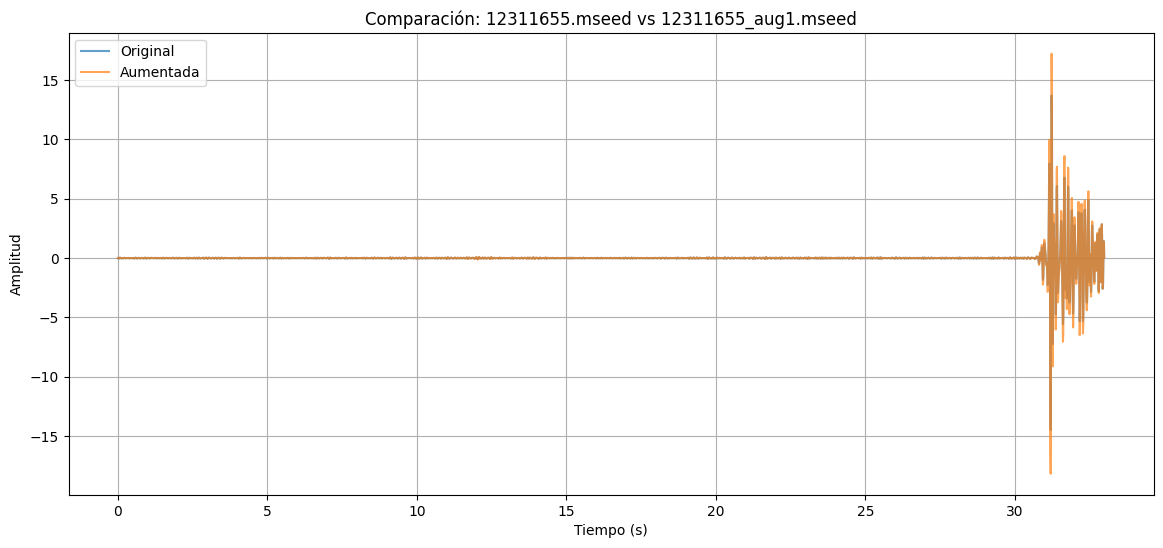

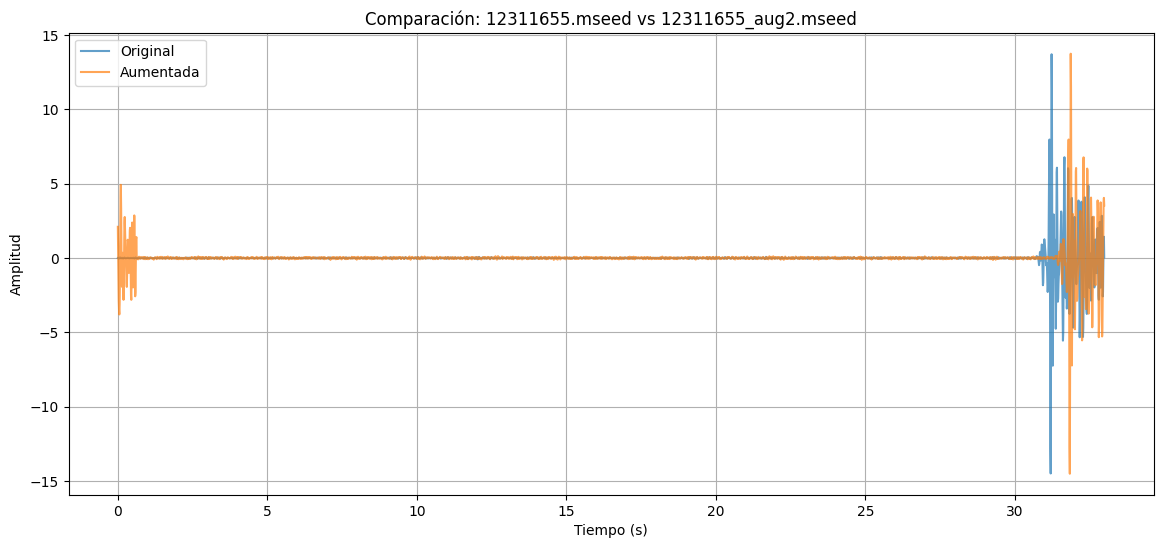

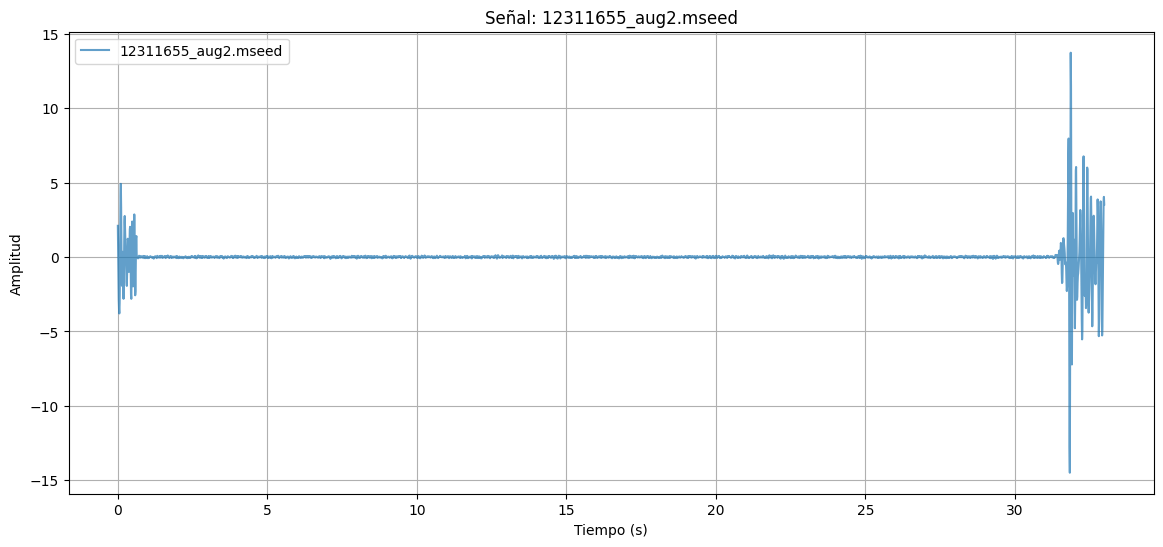

In [ ]:
# graficar señáles especificas y la señal aumentada correspondiente
def plot_signal_and_augmented(file_name, aug_file_name):
    """Grafica la señal original y la aumentada."""
    # Leer señal original
    orig_path = os.path.join(train_data_path, file_name)
    st_orig = read(orig_path)
    tr_orig = st_orig[0]
    times_orig = np.arange(len(tr_orig.data)) / tr_orig.stats.sampling_rate

    # Leer señal aumentada
    aug_path = os.path.join(train_augment_data_ranges_path, aug_file_name)
    st_aug = read(aug_path)
    tr_aug = st_aug[0]
    times_aug = np.arange(len(tr_aug.data)) / tr_aug.stats.sampling_rate

    # Graficar
    plt.figure(figsize=(14, 6))
    plt.plot(times_orig, tr_orig.data, label='Original', alpha=0.7)
    plt.plot(times_aug, tr_aug.data, label='Aumentada', alpha=0.7)
    plt.title(f"Comparación: {file_name} vs {aug_file_name}")
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.legend()
    plt.grid(True)
    plt.show()

# Analisis de la distribución de el shift de hondas especificas 

plot_signal_and_augmented('01010056.mseed', '01010056_range_1_20.mseed')
plot_signal_and_augmented('01010056.mseed', '01010056_range_25_35.mseed')
plot_signal_and_augmented('01011302.mseed', '01011302_range_1_20.mseed')
plot_signal_and_augmented('01011302.mseed', '01011302_range_25_35.mseed')

plot_signal_and_augmented('11050411.mseed', '11050411_aug1.mseed')
plot_signal_and_augmented('11050411.mseed', '11050411_aug2.mseed')
plot_signal_and_augmented('12311655.mseed', '12311655_aug1.mseed')
plot_signal_and_augmented('12311655.mseed', '12311655_aug2.mseed')

#graficar una sola señal
def plot_single_signal(file_name):
    """Grafica una sola señal."""
    # Leer señal
    file_path = os.path.join(train_augment_data_ranges_path, file_name)
    st = read(file_path)
    tr = st[0]
    times = np.arange(len(tr.data)) / tr.stats.sampling_rate

    # Graficar
    plt.figure(figsize=(14, 6))
    plt.plot(times, tr.data, label=file_name, alpha=0.7)
    plt.title(f"Señal: {file_name}")
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_single_signal('12311655_aug2.mseed')

In [ ]:
# mirar la distrubución de los tiempos de llegada en el data set
def plot_arrival_time_distribution(arrival_times_df):
    """Grafica la distribución de los tiempos de llegada."""
    plt.figure(figsize=(12, 6))
    plt.hist(arrival_times_df['arrival_time'], bins=50, alpha=0.7)
    plt.title('Distribución de tiempos de llegada')
    plt.xlabel('Tiempo de llegada (s)')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()
    
# contar cuantos datos hay en cada intervalo de tiempo
def count_arrival_times_in_intervals(arrival_times_df, intervals):
    """Cuenta cuántos tiempos de llegada caen en cada intervalo dado.
    Args:
        arrival_times_df: DataFrame con tiempos de llegada
        intervals: lista de tuplas (inicio, fin) para los intervalos
    Returns:
        DataFrame con conteos por intervalo
    """
    counts = []
    for start, end in intervals:
        count = ((arrival_times_df['arrival_time'] >= start) & 
                 (arrival_times_df['arrival_time'] < end)).sum()
        counts.append({'interval': f"{start}-{end}", 'count': count})
    
    return pd.DataFrame(counts)

# Definir intervalos de tiempo
intervals = [(0, 10), (10,20), (20, 30), (30, 40), (40, 50), (50, 60), (60, 70), (70, 80), (80, 90), (90, 100)]


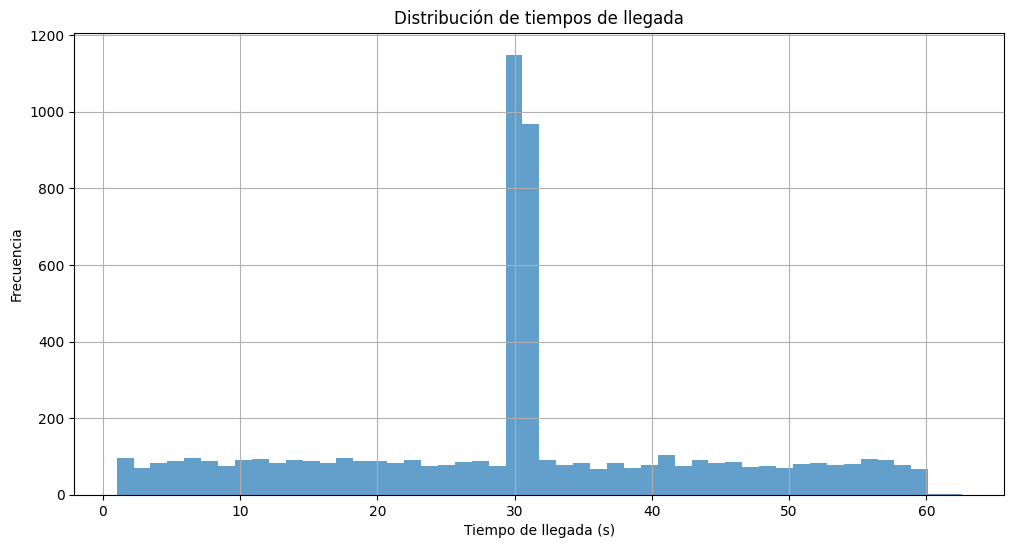


Conteos de tiempos de llegada en intervalos:
  interval  count
0     0-10    627
1    10-20    723
2    20-30    681
3    30-40   2576
4    40-50    671
5    50-60    659
6    60-70      3
7    70-80      0
8    80-90      0
9   90-100      0


In [ ]:
# Analizar la distribución de los tiempos de llegada para los archivos aumentados por rangos 
csv_path = os.path.join(augmented_data_path, 'arrival_times_all.csv')
arrival_times_df = pd.read_csv(csv_path)
plot_arrival_time_distribution(arrival_times_df)


counts_df = count_arrival_times_in_intervals(arrival_times_df, intervals)
print("\nConteos de tiempos de llegada en intervalos:")
print(counts_df)

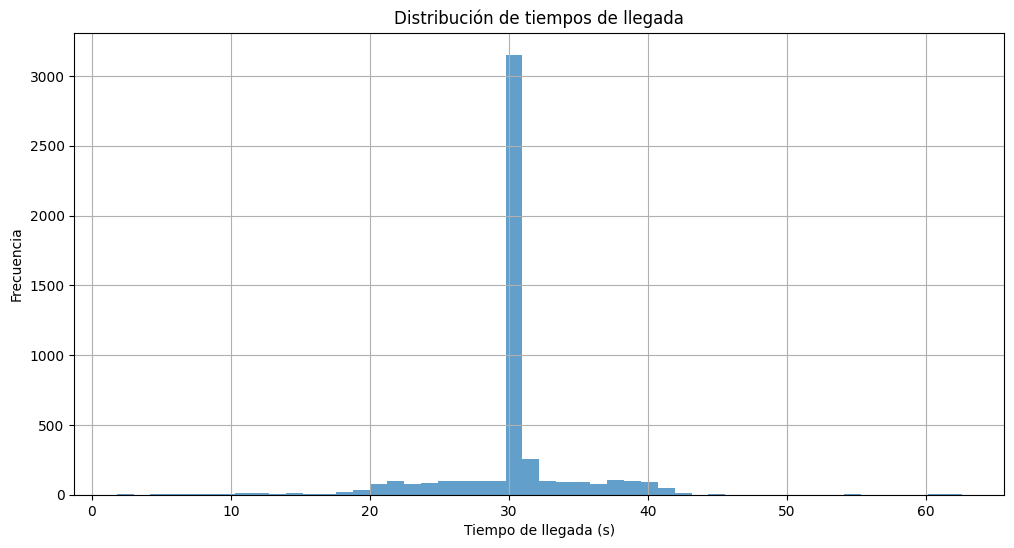


Conteos de tiempos de llegada en intervalos:
  interval  count
0     0-10     31
1    10-20     98
2    20-30    743
3    30-40   3989
4    40-50    119
5    50-60      5
6    60-70      4
7    70-80      0
8    80-90      0
9   90-100      0


In [ ]:
# Analizar la distribución de los tiempos de llegada del dataset v1 augmentado

csv_path = os.path.join(augmented_data_path, 'arrival_times.csv')
arrival_times_df = pd.read_csv(csv_path)

plot_arrival_time_distribution(arrival_times_df)

counts_df = count_arrival_times_in_intervals(arrival_times_df, intervals)
print("\nConteos de tiempos de llegada en intervalos:")
print(counts_df)

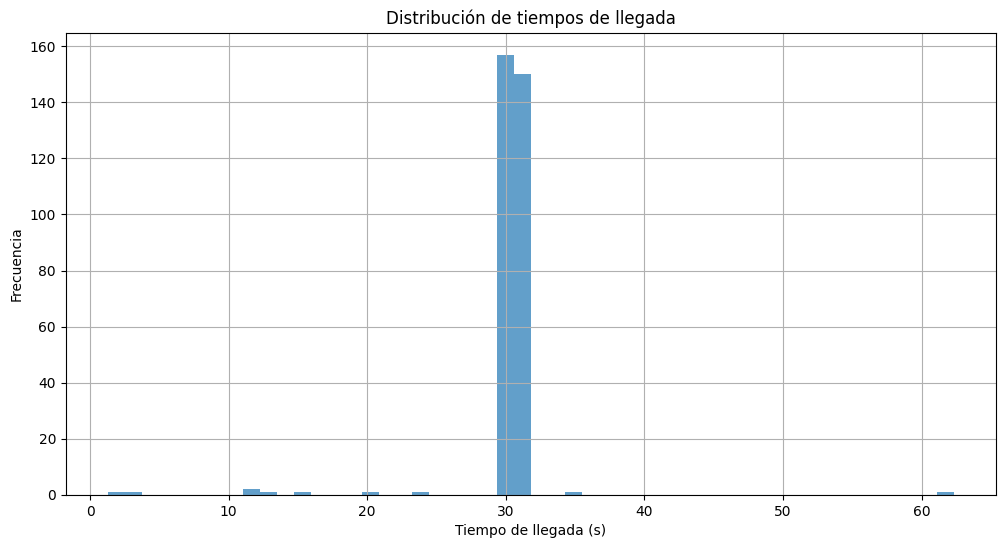


Conteos de tiempos de llegada en intervalos:
  interval  count
0     0-10      2
1    10-20      4
2    20-30      2
3    30-40    308
4    40-50      0
5    50-60      0
6    60-70      1
7    70-80      0
8    80-90      0
9   90-100      0


In [ ]:
feature_path = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/features'
# Analizar la  distribución de los tiempos de llegada en el conjunto de validación
csv_path = os.path.join(feature_path, 'val_arrival_times.csv')
arrival_times_df = pd.read_csv(csv_path)

plot_arrival_time_distribution(arrival_times_df)

counts_df = count_arrival_times_in_intervals(arrival_times_df, intervals)

print("\nConteos de tiempos de llegada en intervalos:")
print(counts_df)

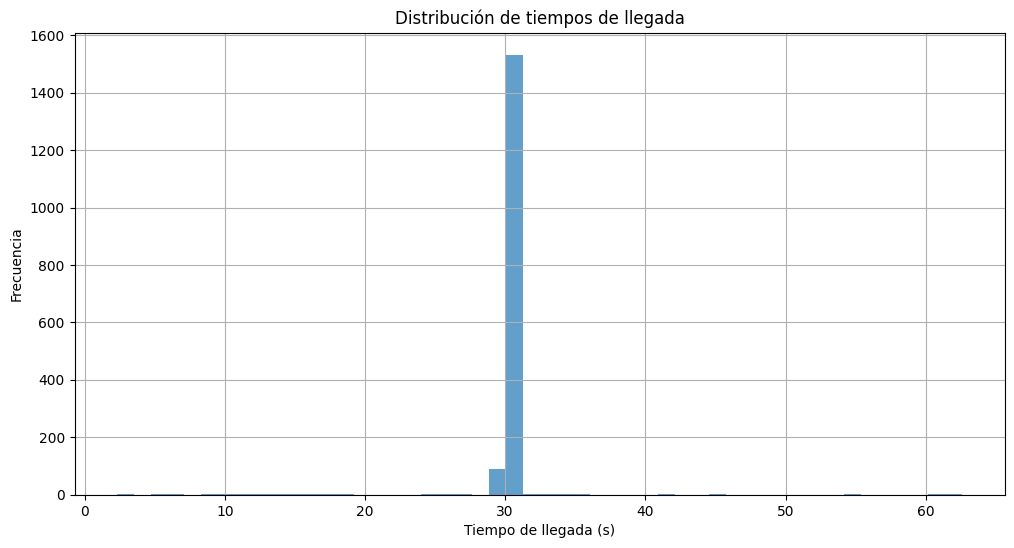


Conteos de tiempos de llegada en intervalos:
  interval  count
0     0-10     10
1    10-20     20
2    20-30      4
3    30-40   1624
4    40-50      2
5    50-60      1
6    60-70      2
7    70-80      0
8    80-90      0
9   90-100      0


In [ ]:
# Analizar la distribución de los tiempos de llegada en el conjunto de entrenamiento 
csv_path = os.path.join(feature_path, 'train_arrival_times.csv')
arrival_times_df = pd.read_csv(csv_path)
plot_arrival_time_distribution(arrival_times_df)

counts_df = count_arrival_times_in_intervals(arrival_times_df, intervals)

print("\nConteos de tiempos de llegada en intervalos:")
print(counts_df)

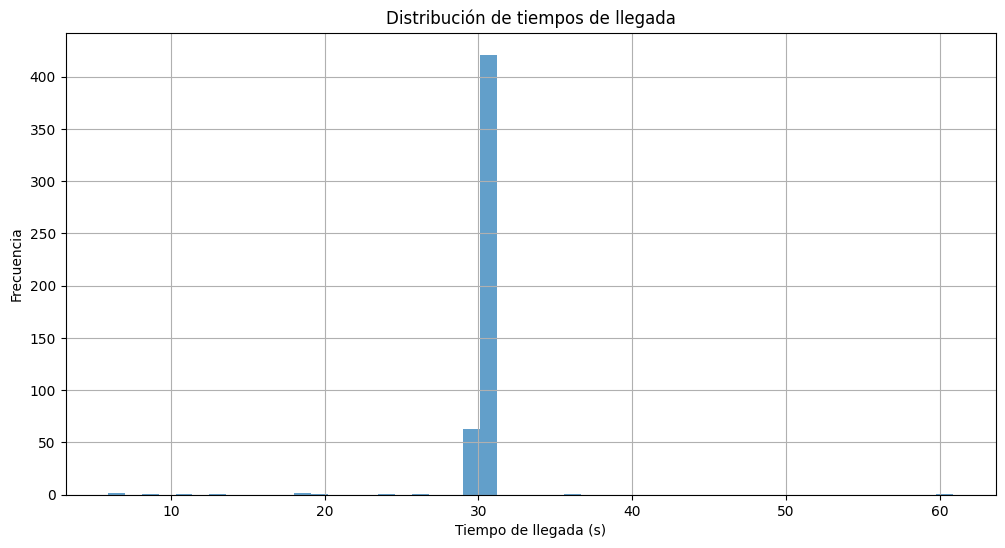


Conteos de tiempos de llegada en intervalos:
  interval  count
0     0-10      3
1    10-20      5
2    20-30      3
3    30-40    484
4    40-50      0
5    50-60      0
6    60-70      1
7    70-80      0
8    80-90      0
9   90-100      0


In [ ]:
# Analizar la distribución de tiempos de llegada en el conjunto de prueba
csv_path = os.path.join(feature_path, 'test_arrival_times.csv')
arrival_times_df = pd.read_csv(csv_path)

plot_arrival_time_distribution(arrival_times_df)



counts_df = count_arrival_times_in_intervals(arrival_times_df, intervals)

print("\nConteos de tiempos de llegada en intervalos:")
print(counts_df)


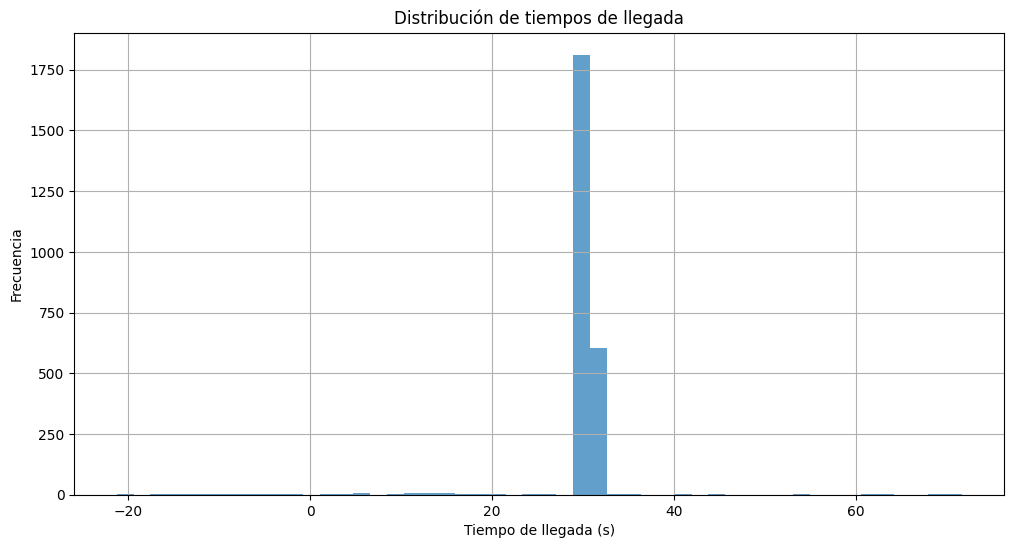


Conteos de tiempos de llegada en intervalos:
  interval  count
0     0-10     15
1    10-20     29
2    20-30      9
3    30-40   2420
4    40-50      2
5    50-60      1
6    60-70      5
7    70-80      1
8    80-90      0
9   90-100      0


In [ ]:
# Analizar distribución de todos los datos de entrenamiento 
original_data = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed'
csv_path = os.path.join(original_data, 'analized_data.csv')
arrival_times_df = pd.read_csv(csv_path)
plot_arrival_time_distribution(arrival_times_df)



counts_df = count_arrival_times_in_intervals(arrival_times_df, intervals)

print("\nConteos de tiempos de llegada en intervalos:")
print(counts_df)